In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

### Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)

Define a test problem

In [2]:
K = 5 
theta_true = np.ones(K) 
a, b = -1,1
N = 100

X shape :(100,).


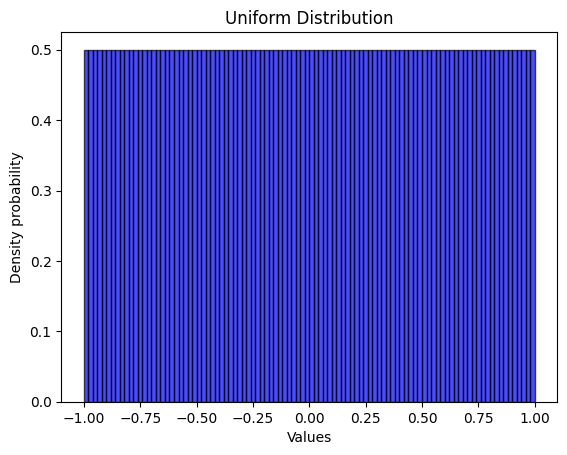

In [3]:
# Define an input dataset X = [x1 x2 . . . xN ] ∈ R^N , where the xi are N uniformly distributed datapoints in the interval 
# [a, b], where a < b are values that the user can select

X = np.linspace(a, b, N)
print("X shape :{}.".format(X.shape))

# Visualizza il plot
plt.hist(X, bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Uniform Distribution')
plt.xlabel('Values')
plt.ylabel('Density probability')
plt.show()

In [4]:
def generalized_vandermonde_matrix(func_list, X):
    matrix = np.column_stack([func(X) for func in func_list])
    return matrix

# ϕj (x) = x^j−1 
def phi(j, x):
    return np.power(x, j-1)

def get_vandermonde(K, X):
    vander = generalized_vandermonde_matrix(func_list=[lambda x, j=j: phi(j, x) for j in range(1,K+1)], X=X)
    return vander


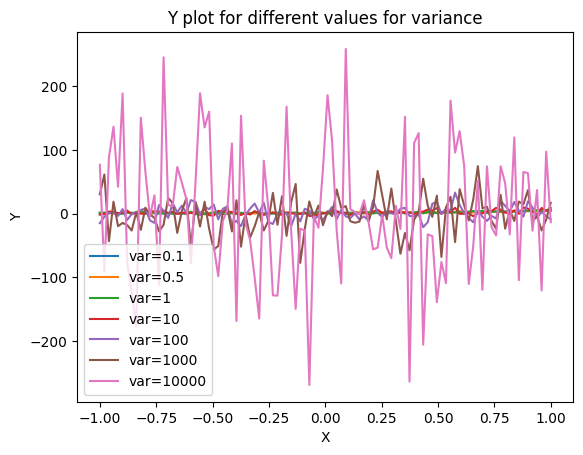

In [5]:
# compute Y = phi(X) @ theta_true + e, where e is the distributed noise with variance var
var = [0.1, 0.5, 1, 10, 100, 1000, 10000]

def compute(K, X, theta, v):
    vander = get_vandermonde(K, X)
    return vander @ theta + np.random.normal(0, np.sqrt(v), size=len(X))

for v in var:
    Y = compute(K, X, theta_true, v)
    
    plt.plot(X, Y, label=f'var={v}')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Y plot for different values for variance')
plt.show()

# only very big value of variance are impactful on the result

In [6]:
# 2 We now built a dataset D = {X, Y} such that θtrue = (1, 1, . . . , 1) ∈ R^K is the best solution to the least squares problem Φ(X)θ ≈ Y .
# K_true = 5 definito all'inizio

Y = compute(K, X, theta_true, v=0.15) 
D = (X,Y)
print(Y.shape)

(100,)


In [7]:
np.random.seed(42)

idx = np.arange(N)
np.random.shuffle(idx)
N_train = int(N/4*3)

train_idx = idx[:N_train]
test_idx = idx[N_train:]

Xtrain = X[train_idx]
Ytrain = Y[train_idx]
Xtest = X[test_idx]
Ytest = Y[test_idx]

Dtrain = (Xtrain, Ytrain)
Dtest = (Xtest, Ytest)

print(Xtrain.shape, Xtest.shape)

(75,) (25,)


### Using general MSE loss function for the problem

def loss(vander, Y, theta):

    return np.linalg.norm((vander @ theta) - Y, 2)**2/(len(Y)*2) # *2 for semplification

def grad_loss(vander, Y, theta):

    return (vander.T @ (vander @ theta -Y)) / len(Y)

### Using loss function for MAP and MLE methods

In [57]:
# use one function with l = 0 for MLE and l != 0 for MAP
def loss(vander, Y, theta, l):
    return (1/2) * np.linalg.norm((vander @ theta) - Y)**2 + (l/2) * np.linalg.norm(theta)**2

def grad_loss(vander, Y, theta, l):
    return vander.T @ ((vander @ theta) - Y) + l * theta

Pretend not to know the correct value of K. The first task is to try to guess it and use it to approximate the true solution θtrue by MLE and MAP

In this case the learning problem is in the form of Least Square problem, so it can be resolved by the Normal Equation Method for example or 
methods such as Gradient Descent or Stochastic Gradient Descent.

In particular, the resolution of the optimal parameters of the model is possible because the polynomial regression model 
mantains the linear form with respect to the parameters $θ$, even if it is not linear with respect to the variable $x$.

Considering the Vandermonde matrix help us to treat the problem like a Least Square Problem.

#### Methods for the optimization of the loss function

In [66]:
# Normal Equation
def mle_ne(vander, Y):
    return np.linalg.inv(vander.T @ vander) @ vander.T @ Y

def map_ne(vander, Y, lam, K):
    return np.linalg.inv(vander.T @ vander - lam * np.identity(K)) @ vander.T @ Y


# GD: Gradient Descent
def check(k, grad_f, wk, wk_1, w0, vander, Y, l, tolf = 1e-6, tolx = 1e-6, kmax = 100):
    c_tolf = np.linalg.norm(grad_f(vander, Y, wk, l))< tolf * np.linalg.norm(grad_f(vander, Y, w0, l))
    c_tolx = tolx > np.linalg.norm(wk - wk_1)
    return k >= kmax or c_tolx or c_tolf

def backtracking(f, Y, grad_f, wk, vander, l):
    alpha = 1
    c = 0.8
    tau = 0.25
    while f(wk - alpha * grad_f(vander, Y, wk, l), Y, wk, l) > f(vander, Y, wk, l) - c * alpha * np.linalg.norm(grad_f(vander, Y, wk, l)) ** 2:
        alpha = tau * alpha
        if alpha < 1e-3:
            break
    return alpha

def GD_back(K, grad_func, w0, data, loss, l = 0):
    X, Y = data
    vander = get_vandermonde(K, X)
    w = [w0]
    k = 0
    condition = True
    while condition:
        alpha = backtracking(loss, Y, grad_func, w[k], vander, l)
        w_n = w[k] - alpha * grad_func(vander, Y, w[k], l)
        k += 1
        condition = not check(k, grad_func, w_n, w[k-1], w[0], vander, Y, l)
        w.append(w_n)  

    grads = [grad_func(vander, Y, wk, l) for wk in w]
    return w, k, [loss(vander, Y, wk, l) for wk in w], grads, [np.linalg.norm(e) for e in grads]



# SGD: Stocastic Gradient Descent
def SGD(K, loss, grad_func, w0, data, l = 0, batch_size=40, n_epochs=4000):
    alpha = 1e-4
    X, Y = data
    w = [w0]
    loss_val = []
    grads_val = []
    err_val = []
    for n in range(n_epochs):
        indeces = np.arange(len(Y))
        np.random.shuffle(indeces)
        X = X[indeces]
        Y = Y[indeces]
        for i in range(0, len(Y), batch_size):
            batch_X = X[i:i+batch_size]
            batch_Y = Y[i:i+batch_size]
            vander = get_vandermonde(K, batch_X)
            w_n = w[-1] - alpha*grad_func(vander, batch_Y, w[-1], l)
            w.append(w_n)
        
        vander = get_vandermonde(K, X)
        loss_val.append(loss(vander, Y, w[-1], l))
        grads_val.append(grad_func(vander, Y, w[-1], l))
        err_val.append(np.linalg.norm(grads_val[-1])**2)

    return w, loss_val, grads_val, err_val


In [10]:
def compute_f_theta(K, X, theta):
    vander = get_vandermonde(K, X)
    return vander @ theta

def avg_error(D, theta):
    X, Y = D # Test-set 
    return 1/len(X) * (np.linalg.norm(compute_f_theta(X=X, K=len(theta), theta=theta) - Y)**2)


# For K greater than the true degree of the polynomial, define Err(θ) = ||θ−θtrue||2/||θtrue||2 , where θtrue has been padded with zeros 
# to match the shape of θ. Compute Err(θMLE) and Err(θMAP ) for increasing values of K and different values of λ.
def err_theta_true(theta, theta_true):
    if len(theta_true) < len(theta):
        dim_difference = len(theta) - len(theta_true)
        padded_theta_true = np.pad(theta_true, (0, dim_difference), 'constant')
        return np.linalg.norm(theta - padded_theta_true) / np.linalg.norm(padded_theta_true)
    else:
        return np.linalg.norm(theta - theta_true) / np.linalg.norm(theta_true)
     

### MLE analysis

In [11]:
K_values_mle = [1, 2, 3, 4, 5, 10, 20]

theta_mle = []
thetas_error_mle = []
train_errors_mle = []
test_errors_mle = []

for k in K_values_mle: 
    vander = get_vandermonde(k, Xtrain)
    theta = mle_ne(vander, Ytrain)
    if k > K:
        theta_error = err_theta_true(theta, theta_true)
        thetas_error_mle.append(theta_error)
    theta_mle.append(theta)
    train_errors_mle.append(avg_error(D=Dtrain, theta=theta))
    test_errors_mle.append(avg_error(D=Dtest, theta=theta))

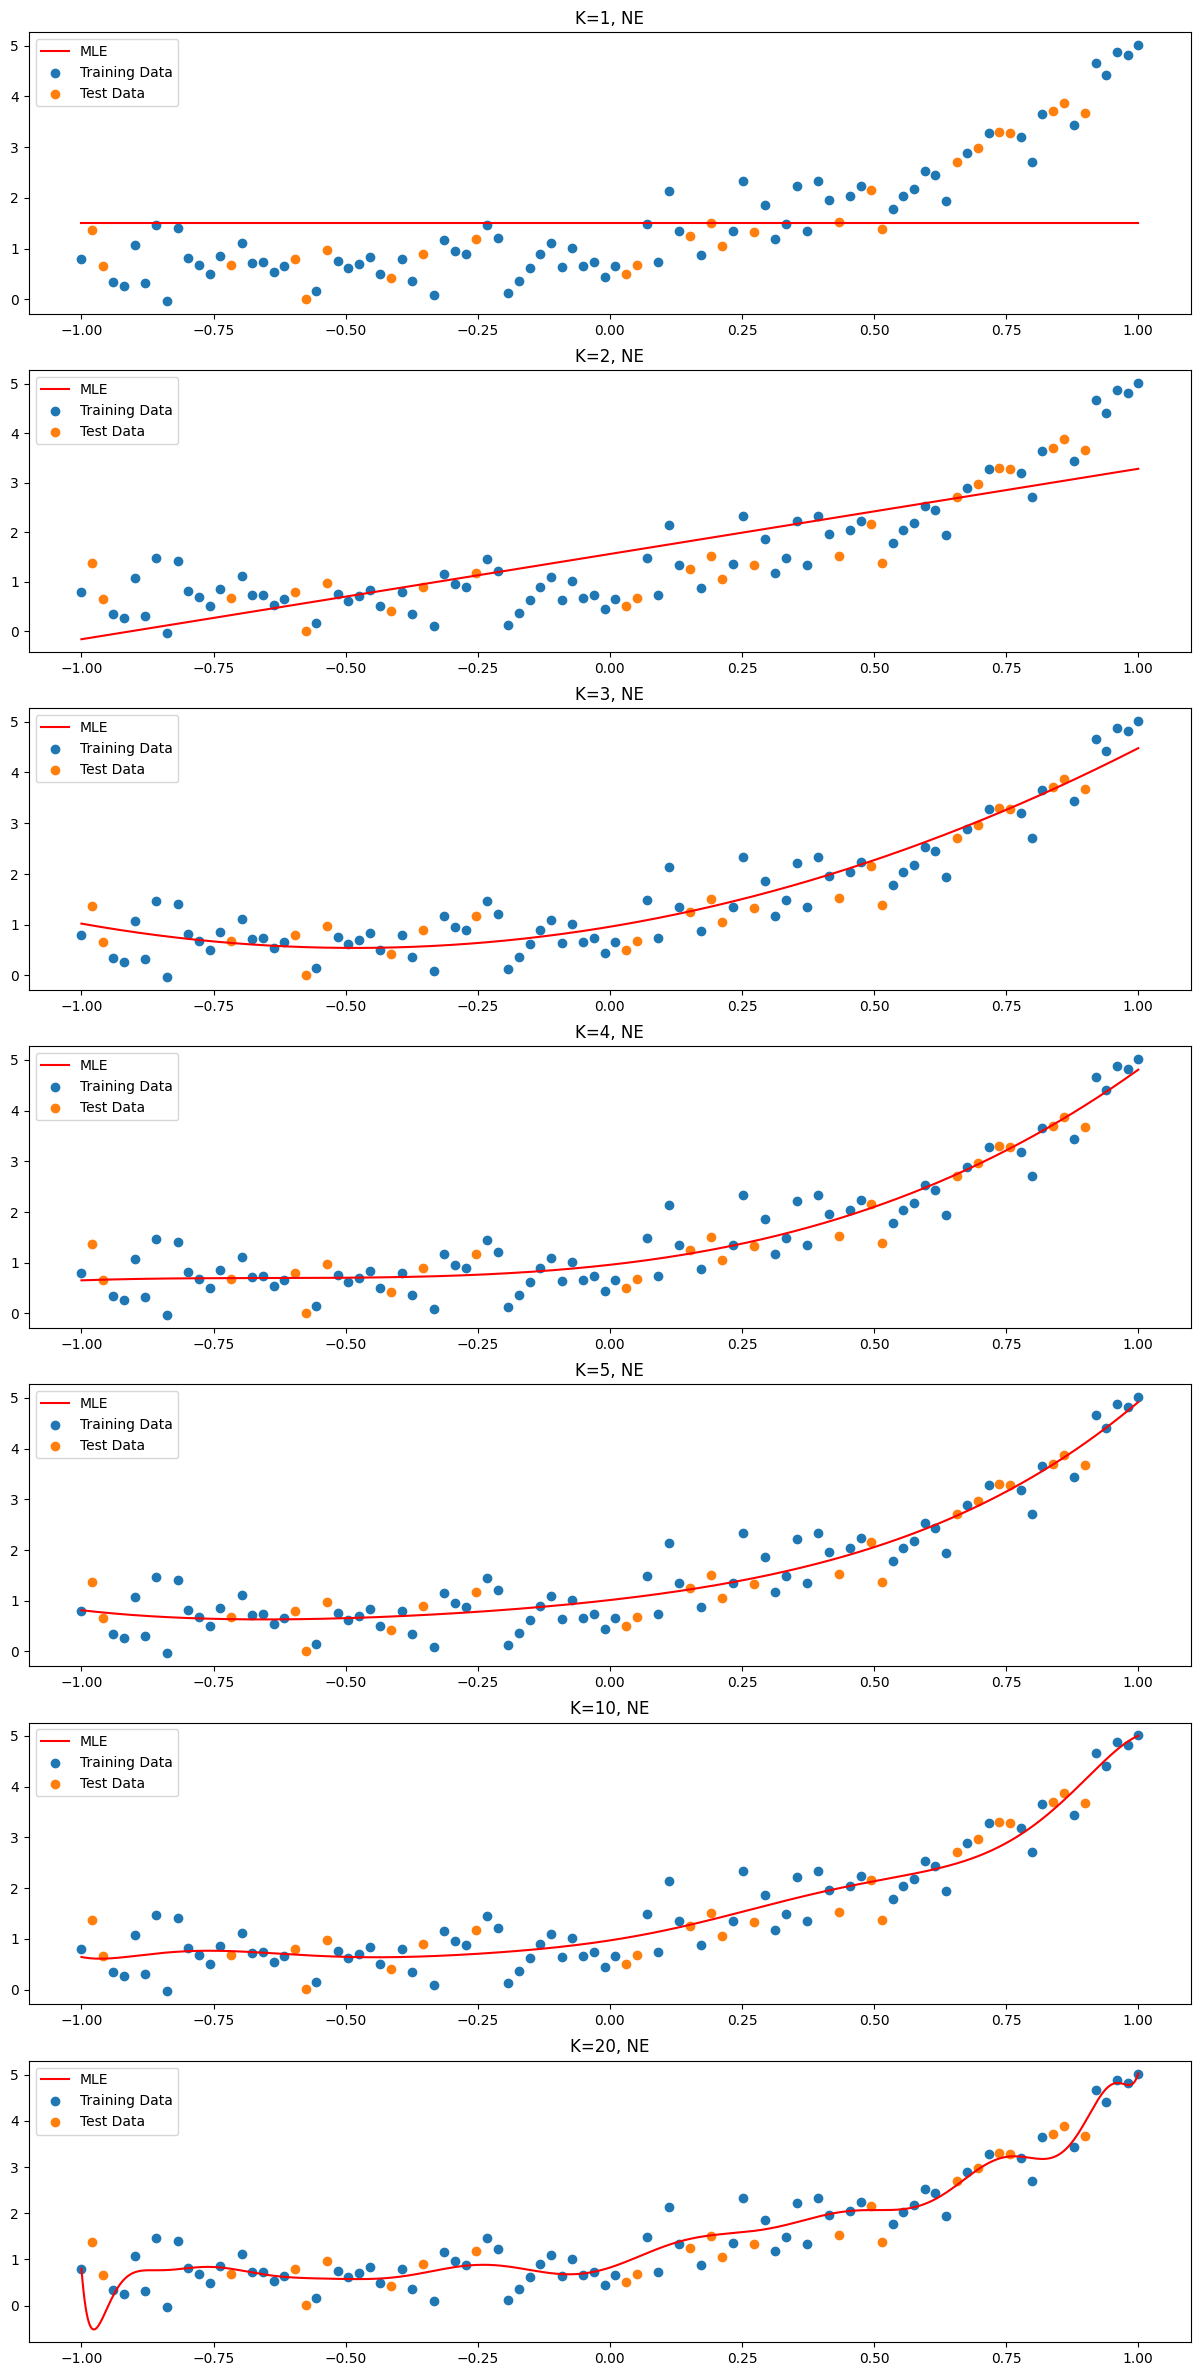

In [12]:
fig, axes = plt.subplots(nrows=len(K_values_mle), figsize = (15, 30))

for i, ax in enumerate(axes):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = compute_f_theta(K=K_values_mle[i], X=X_plot, theta=theta_mle[i]) # without noise
    ax.plot(X_plot, Y_plot, label = f"MLE", color="red")
    ax.scatter(Xtrain, Ytrain, label="Training Data")
    ax.scatter(Xtest, Ytest, label = "Test Data")
    ax.set_title("K=" + str(K_values_mle[i]) + ", NE")
    ax.legend()
plt.show()

With K = 20 we can see an increment in term of overfitting

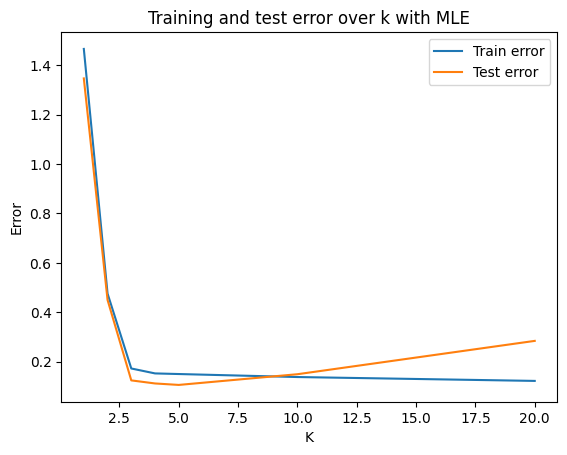

In [13]:
# Plot Training and test error with respect to K
plt.plot(K_values_mle, train_errors_mle, label = "Train error")
plt.plot(K_values_mle, test_errors_mle, label = "Test error")
plt.legend()
plt.title("Training and test error over k with MLE")
plt.xlabel("K")
plt.ylabel("Error")
plt.show()

With both data, using k = 1 or K=2 we can see the error is pretty big. 
The test error is slightly bigger than Train error overall.
Intresting is that increasing K increase at the same time the test error, obviously -> more overfitting

Probably something near k = 10 would be good with respect to overfitting

### MAP with fixed lambda and increasing K

In [14]:
K_values_map = [1, 2, 3, 4, 5, 10, 20]

l = 1.2
theta_map = []
train_errors_map = []
test_errors_map = []

for k in K_values_map:
    vander = get_vandermonde(k, Xtrain)
    theta = map_ne(vander, Ytrain, l, k)
    theta_map.append(theta)
    train_errors_map.append(avg_error(D=Dtrain, theta=theta))
    test_errors_map.append(avg_error(D=Dtest, theta=theta))

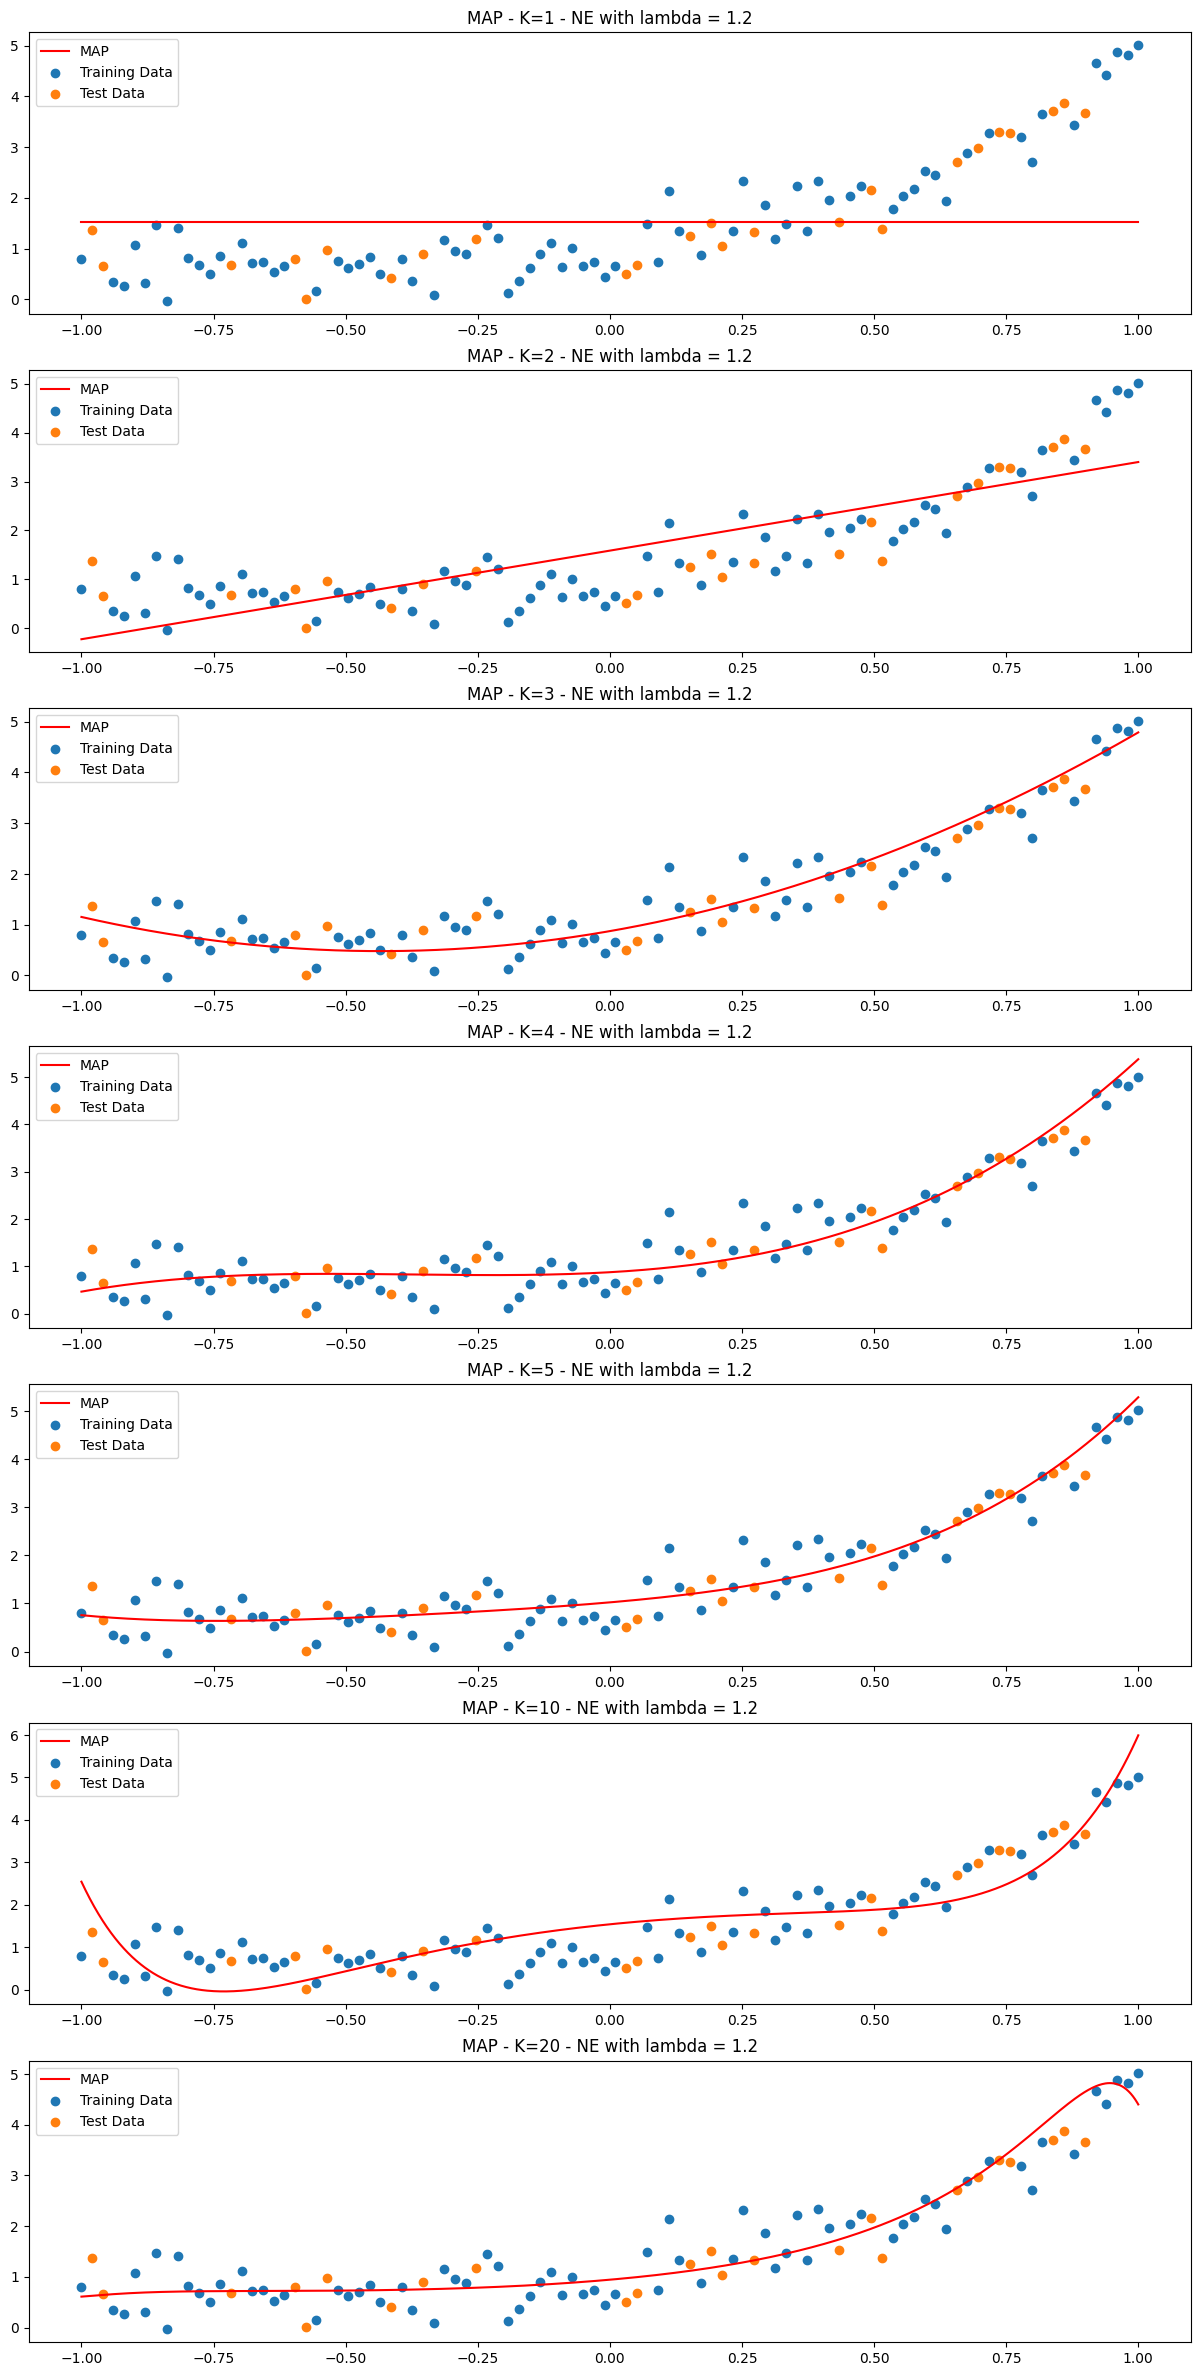

In [15]:
fig, axes = plt.subplots(nrows=len(K_values_map), figsize = (15, 30))

for i, ax in enumerate(axes):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = compute_f_theta(K=K_values_map[i], X=X_plot, theta=theta_map[i]) # without noise
    ax.plot(X_plot, Y_plot, label = f"MAP", color="red")
    ax.scatter(Xtrain, Ytrain, label="Training Data")
    ax.scatter(Xtest, Ytest, label = "Test Data")
    ax.set_title("MAP - K=" + str(K_values_mle[i]) + " - NE with lambda = 1.2")
    ax.legend()
plt.show()

Overfitting is limited in the cases having a bigger K.

The lambda parameter can't regularize the model so well as the number of k increases because it is too small.

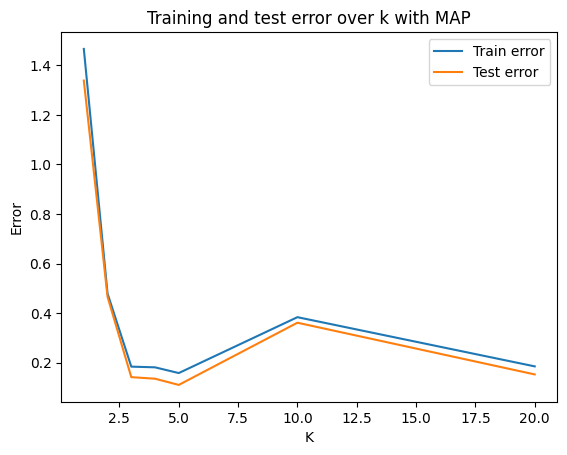

In [16]:
plt.plot(K_values_map, train_errors_map, label = "Train error")
plt.plot(K_values_map, test_errors_map, label = "Test error")
plt.legend()
plt.title("Training and test error over k with MAP")
plt.xlabel("K")
plt.ylabel("Error")
plt.show()

### $MAP$ increasing $K$ and $lambda$

In [17]:
# For K lower, equal and greater than the correct degree of the test polynomial, plot the training datapoints and the test datapoints 
# with different colors, and visualize (as a continuous line) the learnt regression model fθMAP (x) with different values of λ.
lambdas = [0.5, 0.8, 1.2, 6, 30]

theta_map = []

for k in K_values_map:
    theta_map_lambda = []
    vander = get_vandermonde(k, Xtrain)
    for lam in lambdas:
        theta = map_ne(vander, Ytrain, lam, k)
        theta_map_lambda.append(theta)    
    theta_map.append(theta_map_lambda)


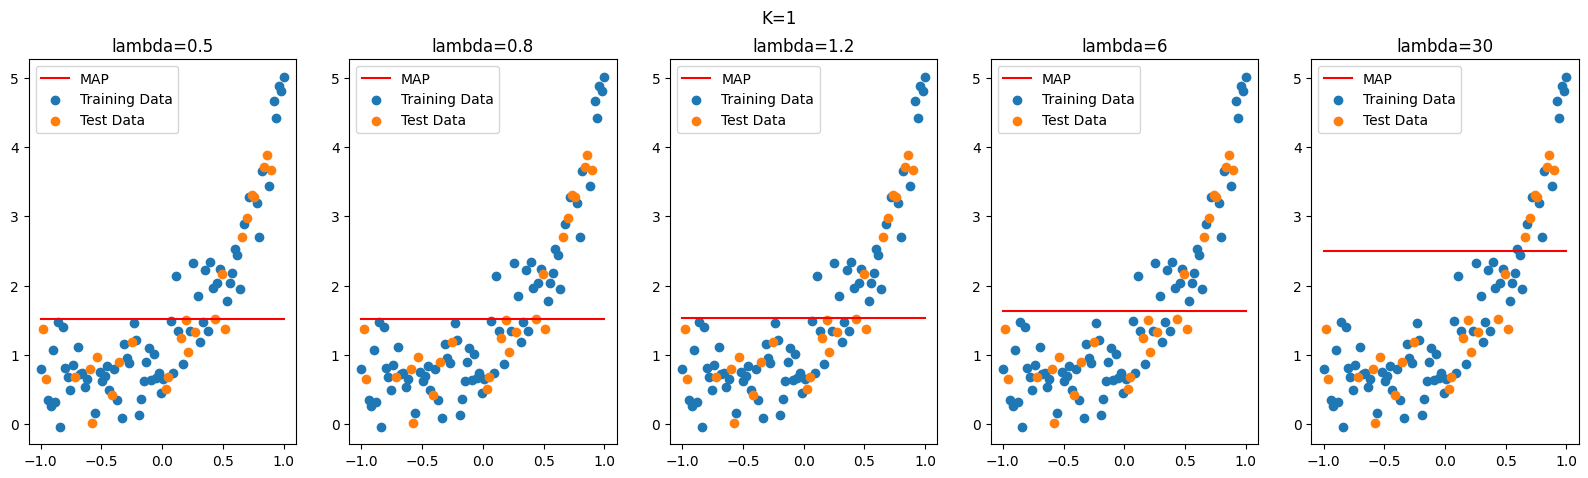

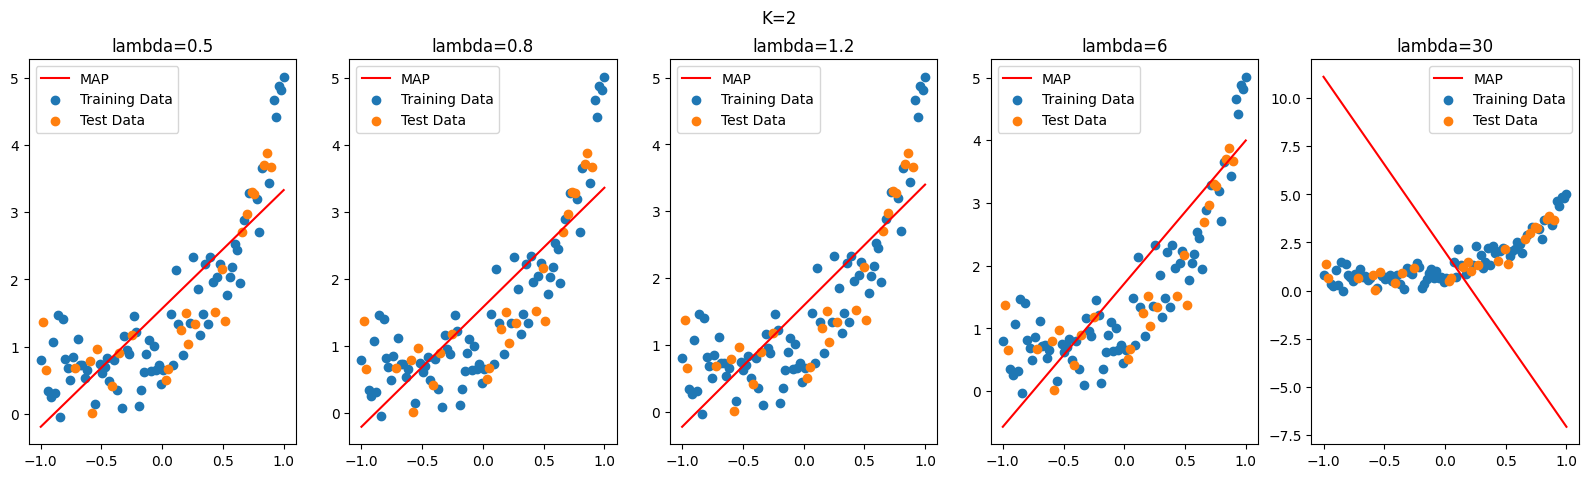

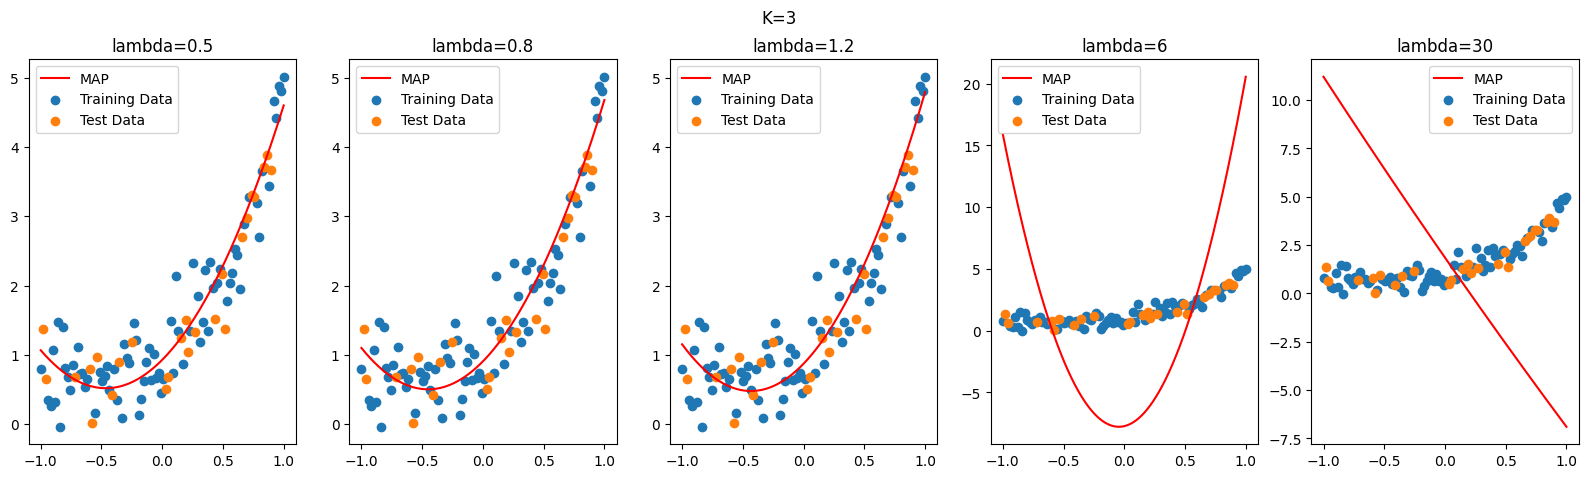

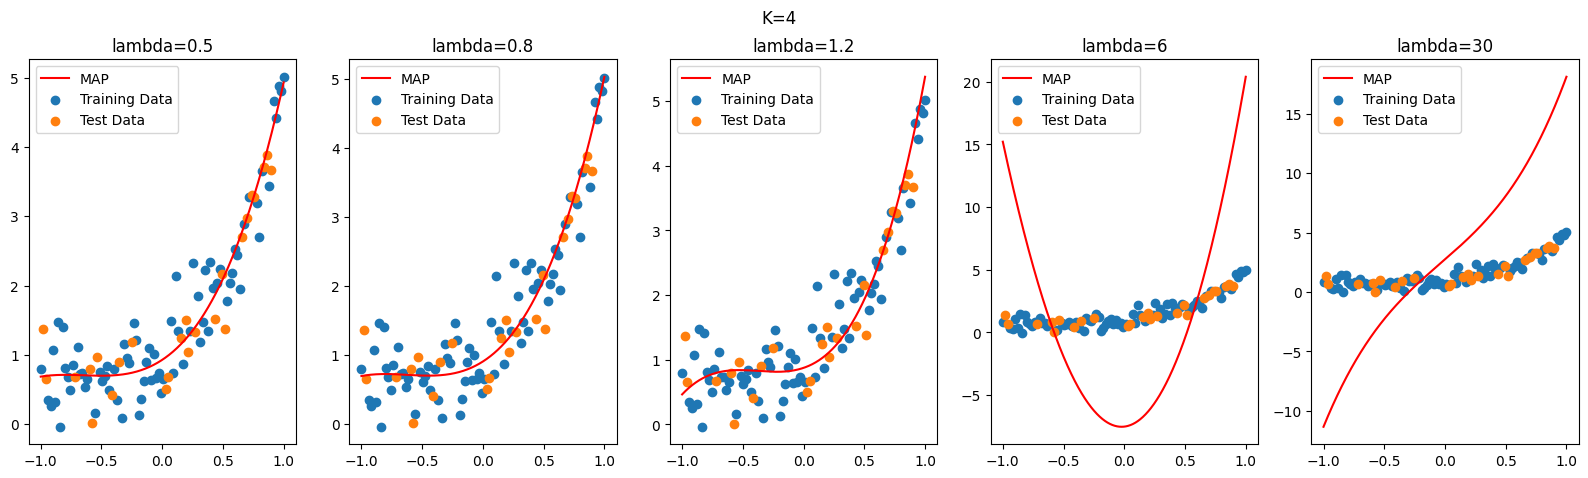

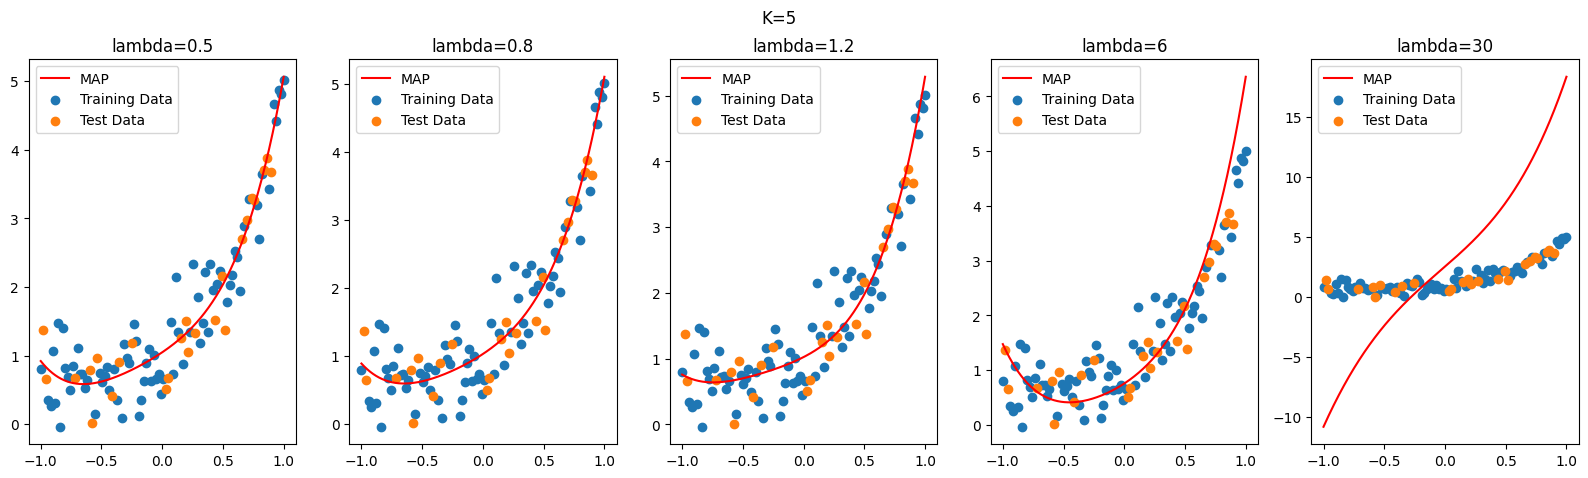

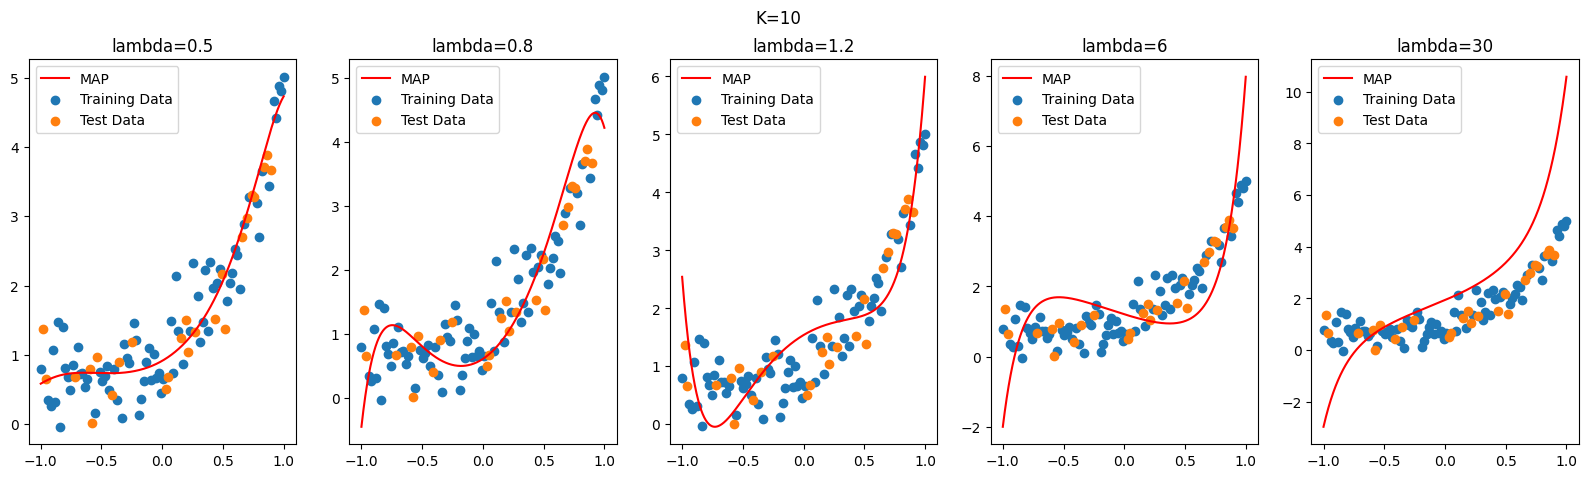

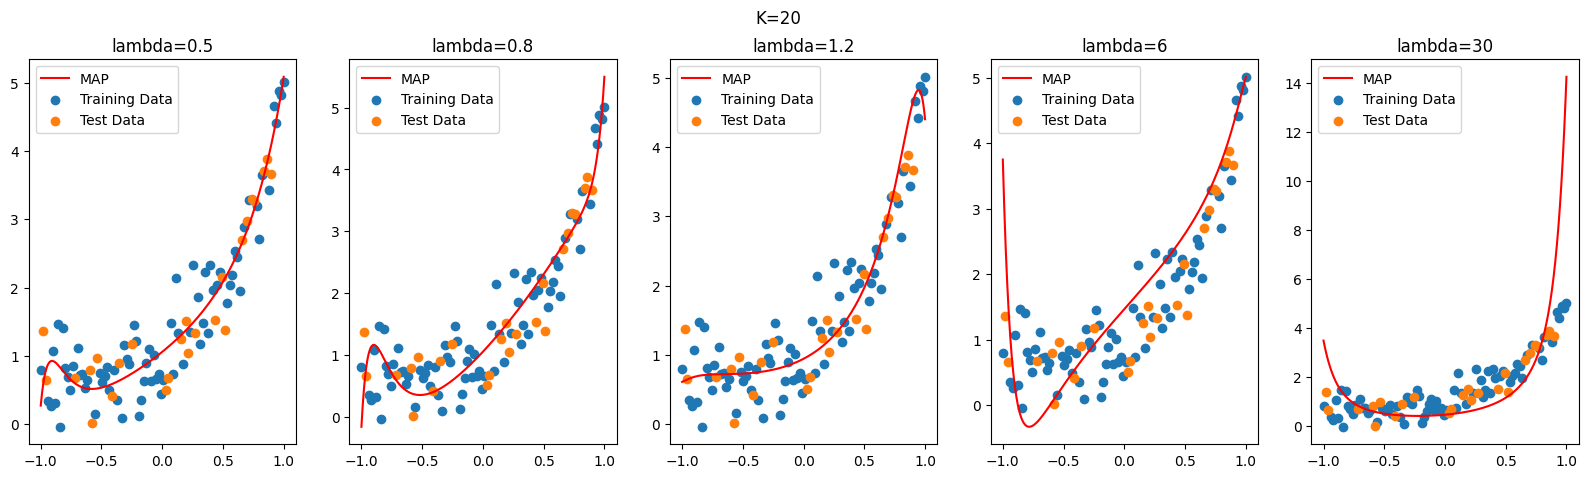

In [18]:
for i in range(len(K_values_map)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K={K_values_map[i]}")

    for j in range(len(lambdas)):
        current_theta = theta_map[i][j]

        X_plot = np.linspace(a, b, 1000)
        Y_plot = compute_f_theta(X=X_plot, K=K_values_map[i], theta=current_theta)
        
        plt.subplot(1, 5, j+1)
        plt.plot(X_plot, Y_plot, label=f"MAP", color="red")
        plt.scatter(Xtrain, Ytrain, label= "Training Data")
        plt.scatter(Xtest, Ytest, label="Test Data")
        plt.title(f"lambda={lambdas[j]}")
        plt.legend() 
plt.show()


as we can see greater values for the regularization parameter(lambda) affect the model in its complexity
the regularization help the model to decrease overfitting
in this case use a big value for lambda it's not important, with lambda 0.5,0.8 or 1.2 the model its pretty balanced in terms of predicting train and test data with lambda = 6 already we can see that the model is too simple for our case, obviously with lambda = 30 the model is affected negatively

In [19]:
# For K lower, equal and greater than the correct degree of the test polynomial, plot the training datapoints and the test datapoints 
# with different colors, and visualize (as a continuous line) the learnt regression model fθMAP (x) with different values of λ.
lambdas = [0.5, 0.8, 1.2, 6, 30]

theta_map = []
thetas_error_map = []
train_errors_map = []
test_errors_map = []

for lam in lambdas:
    theta_map_lambda = []
    train_errors_map_lambda = []
    test_errors_map_lambda = []
    thetas_error_map_lambda = []
    for k in K_values_map:
        vander = get_vandermonde(k, Xtrain)
        theta = map_ne(vander, Ytrain, lam, k)
        if k > K:
            theta_error = err_theta_true(theta, theta_true)
            thetas_error_map_lambda.append(theta_error)
        theta_map_lambda.append(theta)
        train_errors_map_lambda.append(avg_error(D=Dtrain, theta=theta))
        test_errors_map_lambda.append(avg_error(D=Dtest, theta=theta))
        
    thetas_error_map.append(thetas_error_map_lambda)
    test_errors_map.append(test_errors_map_lambda)
    train_errors_map.append(train_errors_map_lambda)
    theta_map.append(theta_map_lambda)


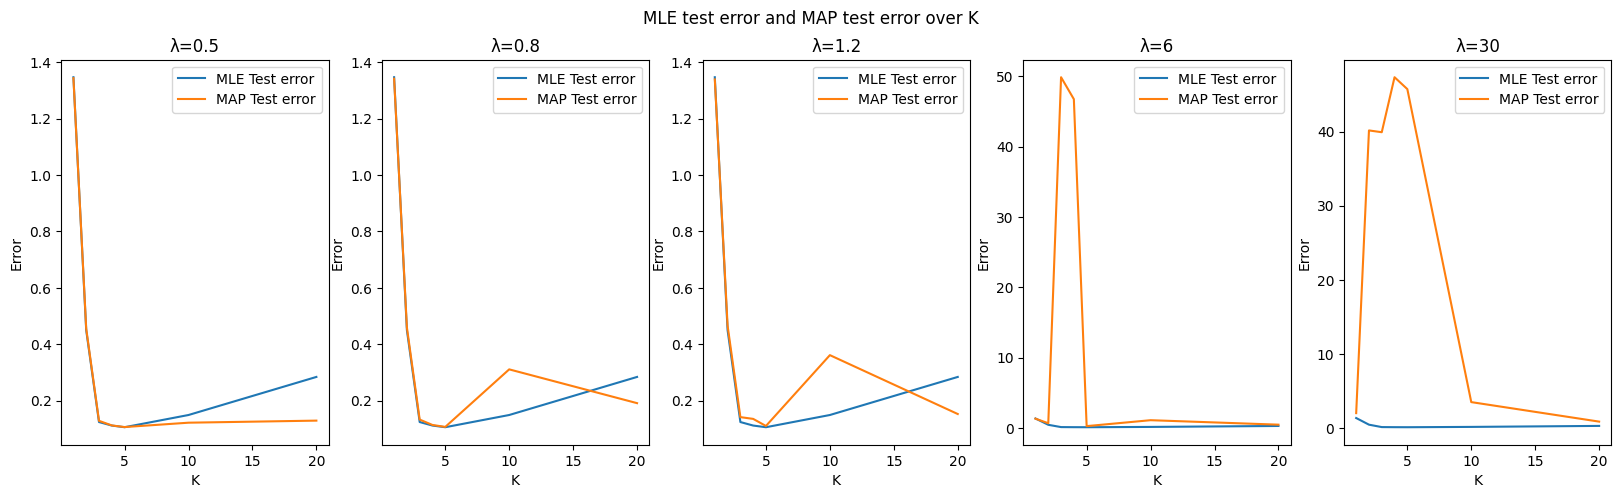

In [20]:
# For K being way greater than the correct degree of the polynomial, compute the MLE and MAP
# solution. Compare the test error of the two, for different values of λ (in the case of MAP).

plt.figure(figsize = (20, 5))
plt.suptitle("MLE test error and MAP test error over K")

for i in range(len(lambdas)):
    plt.subplot(1, 5, i+1)
    plt.plot(K_values_mle, test_errors_mle, label = "MLE Test error")
    plt.plot(K_values_map, test_errors_map[i], label = "MAP Test error")
    plt.legend()
    plt.title(f"λ={lambdas[i]}")
    plt.xlabel("K")
    plt.ylabel("Error")
plt.show()

## K way bigger

In [21]:
K_values = [10, 15, 20, 30, 40, 50] # the K values for this part of experiment

In [22]:
theta_mle = []

for k in K_values: 
    vander = get_vandermonde(k, Xtrain)
    theta = mle_ne(vander, Ytrain)
    theta_mle.append(theta)

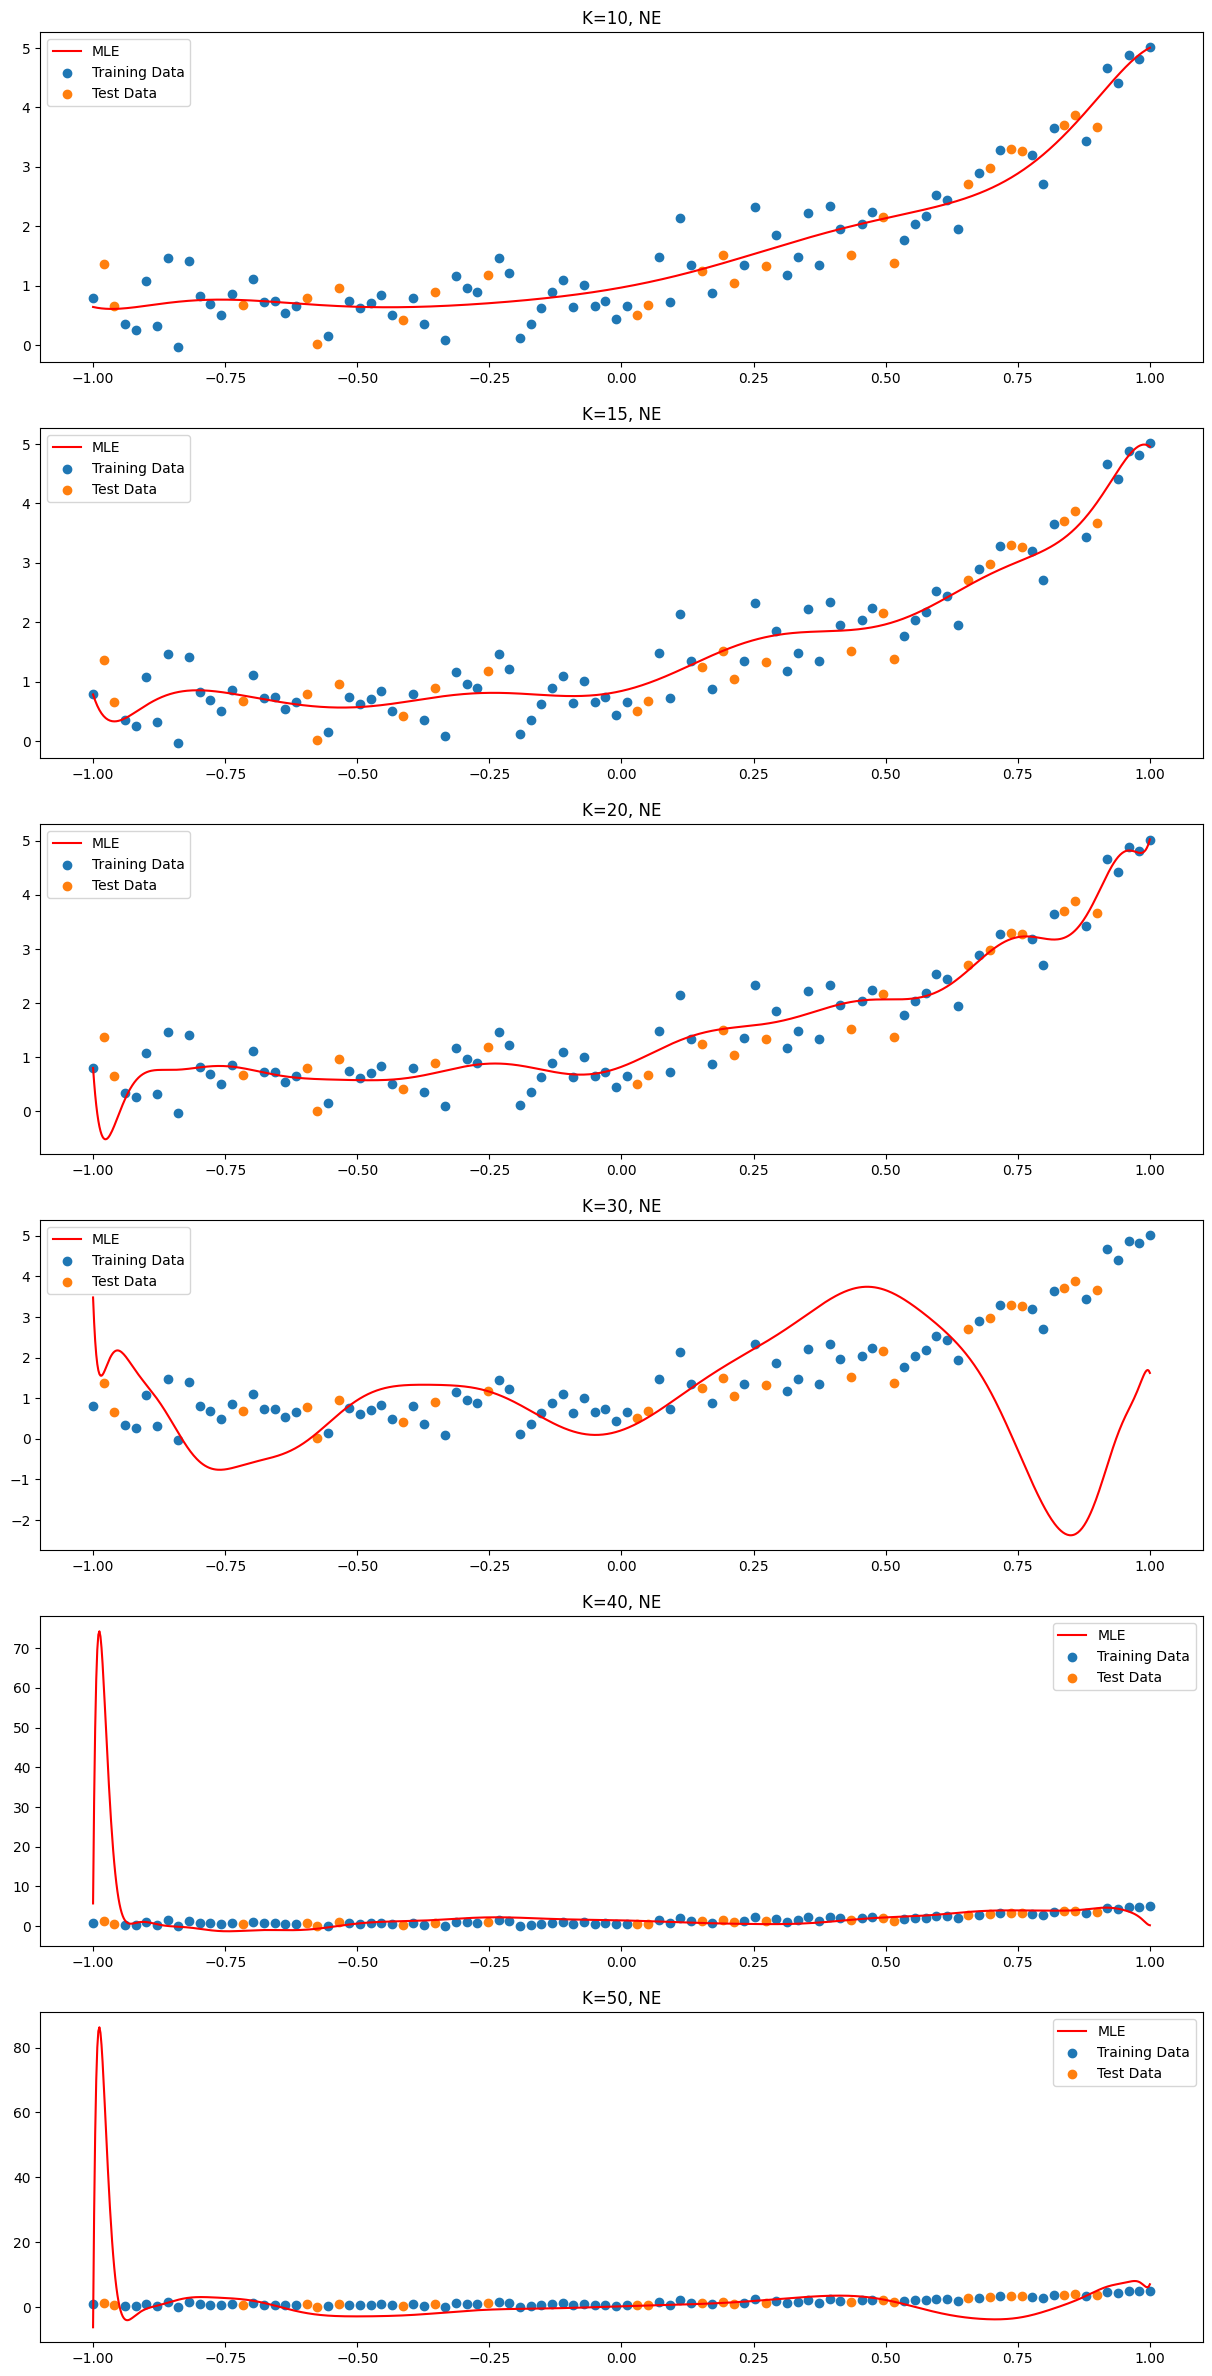

In [23]:
fig, axes = plt.subplots(nrows=len(K_values), figsize = (15, 30))

for i, ax in enumerate(axes):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = compute_f_theta(K=K_values[i], X=X_plot, theta=theta_mle[i]) 
    ax.plot(X_plot, Y_plot, label = f"MLE", color="red")
    ax.scatter(Xtrain, Ytrain, label="Training Data")
    ax.scatter(Xtest, Ytest, label = "Test Data")
    ax.set_title("K=" + str(K_values[i]) + ", NE")
    ax.legend()
plt.show()

The MLE error with K way bigger than the actual theta_true becomes enormous

In [24]:
theta_map = []

for k in K_values:
    theta_map_lambda = []
    vander = get_vandermonde(k, Xtrain)
    for lam in lambdas:
        theta = map_ne(vander, Ytrain, lam, k)
        theta_map_lambda.append(theta)    
    theta_map.append(theta_map_lambda)

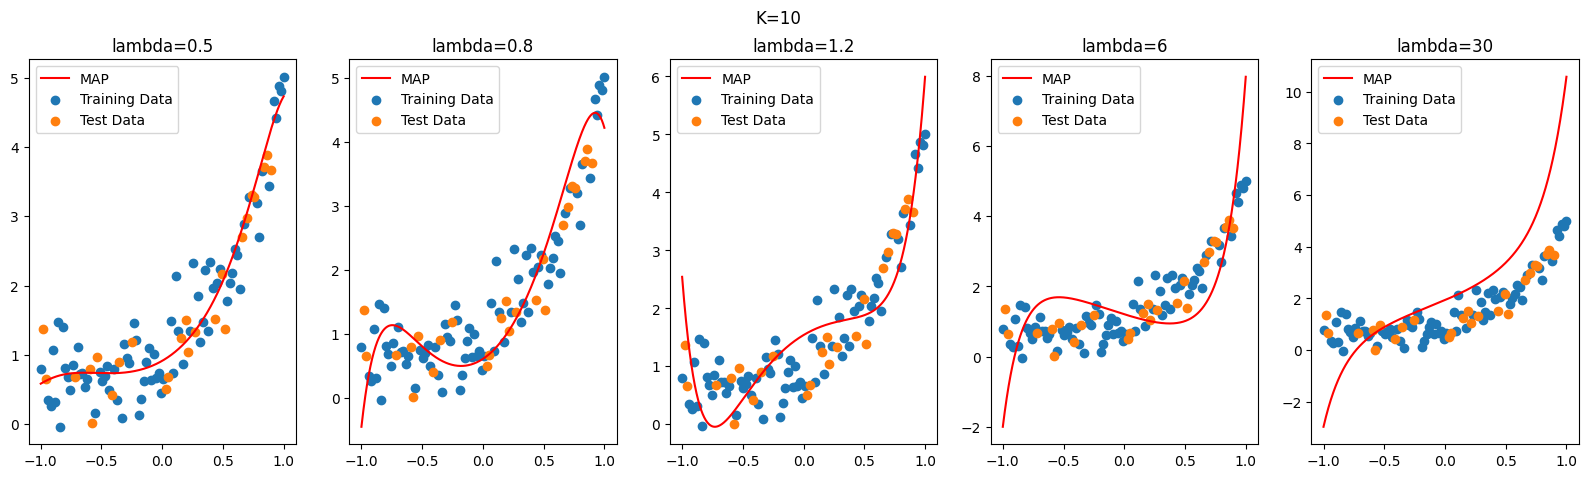

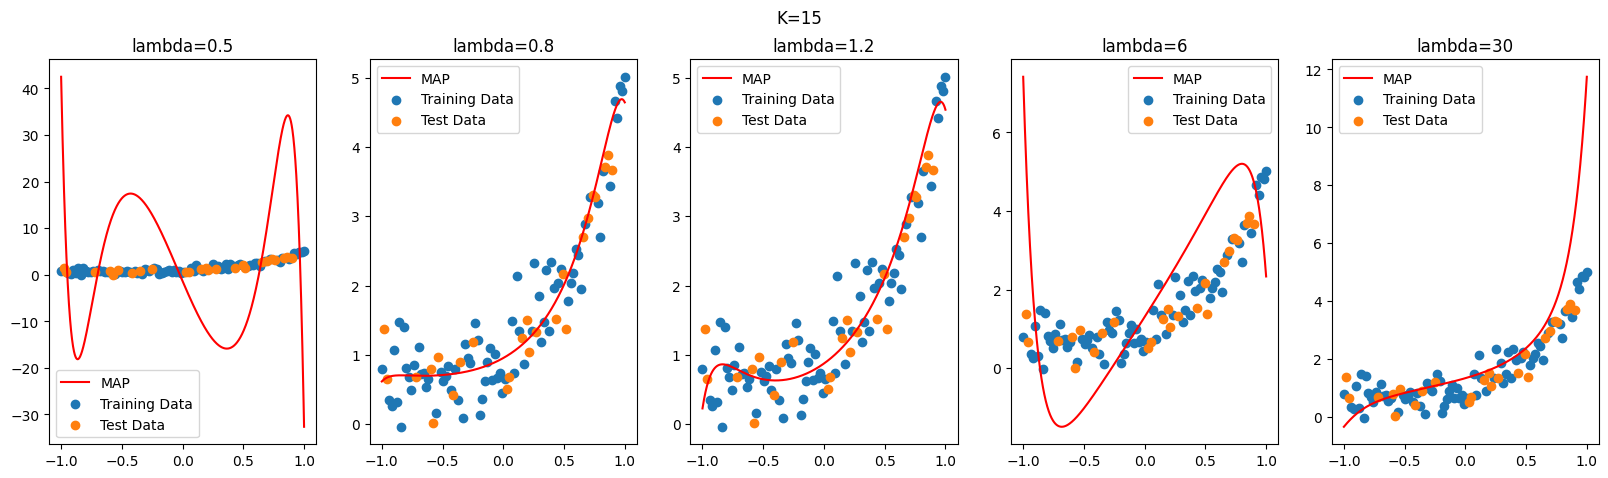

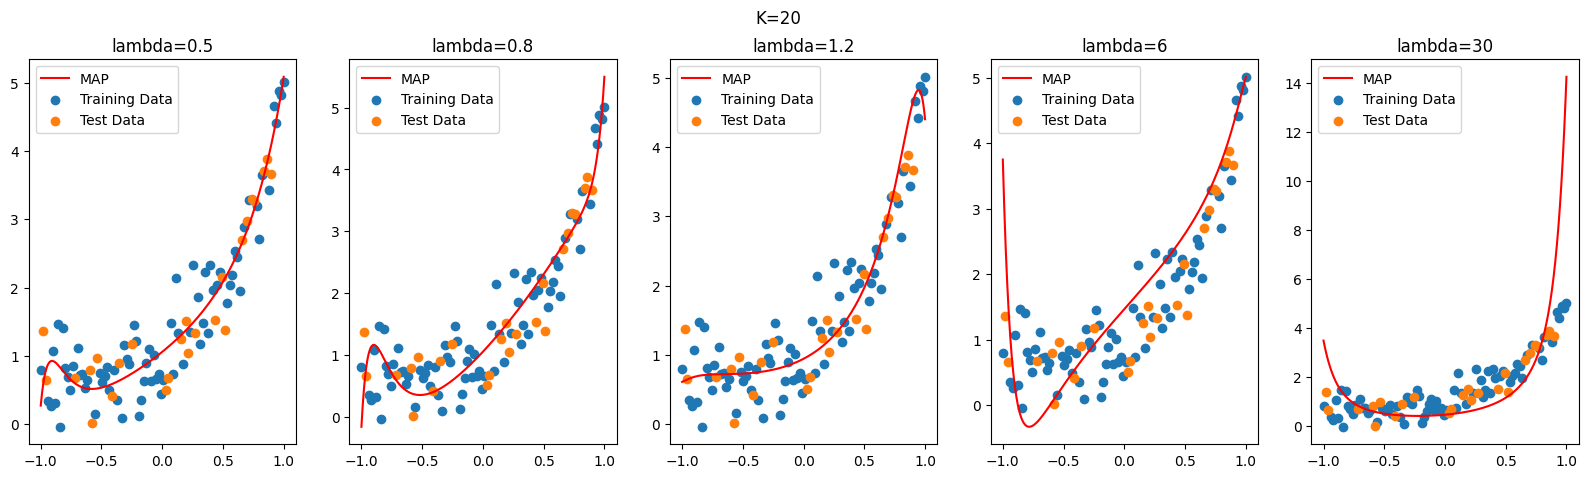

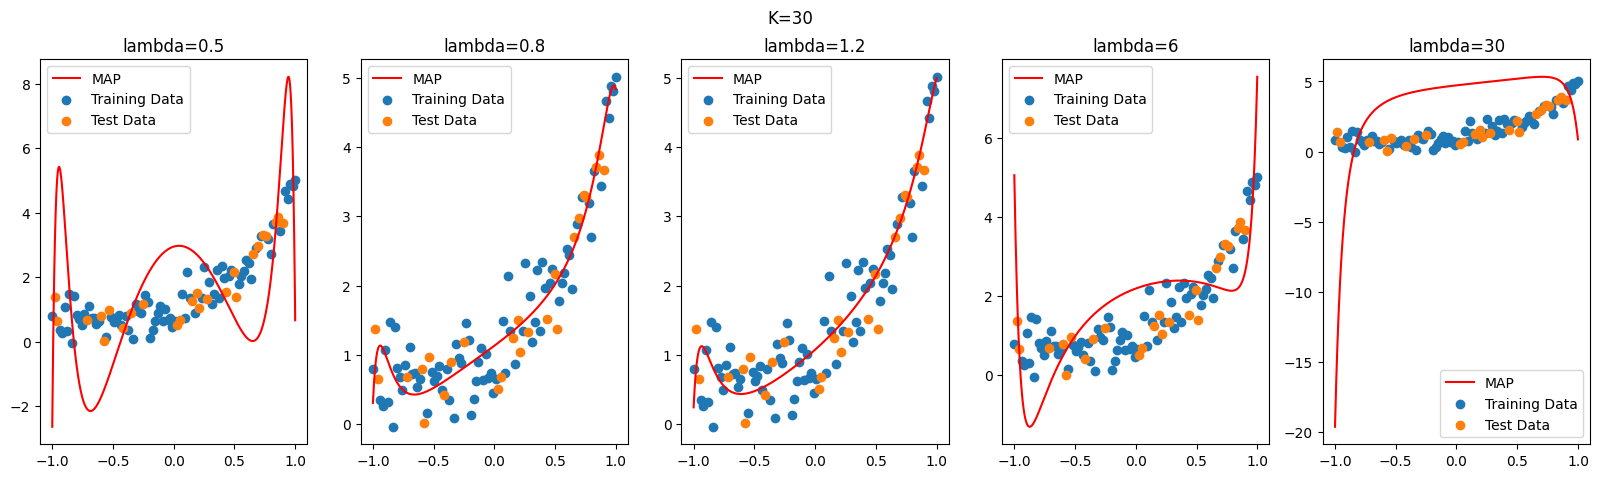

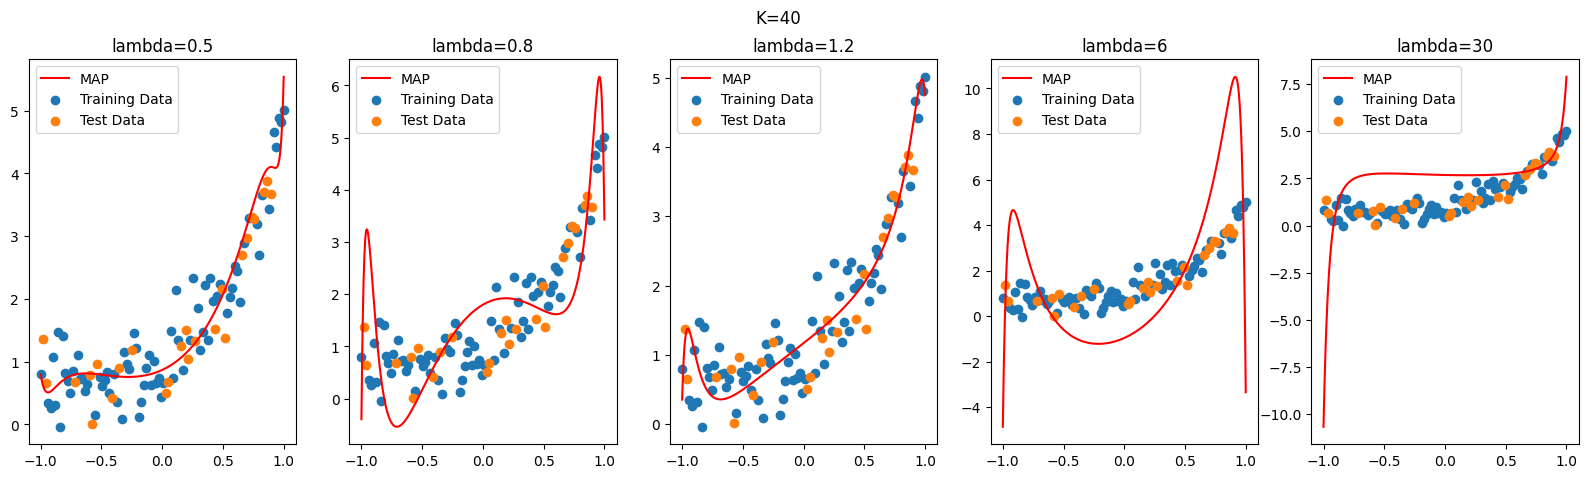

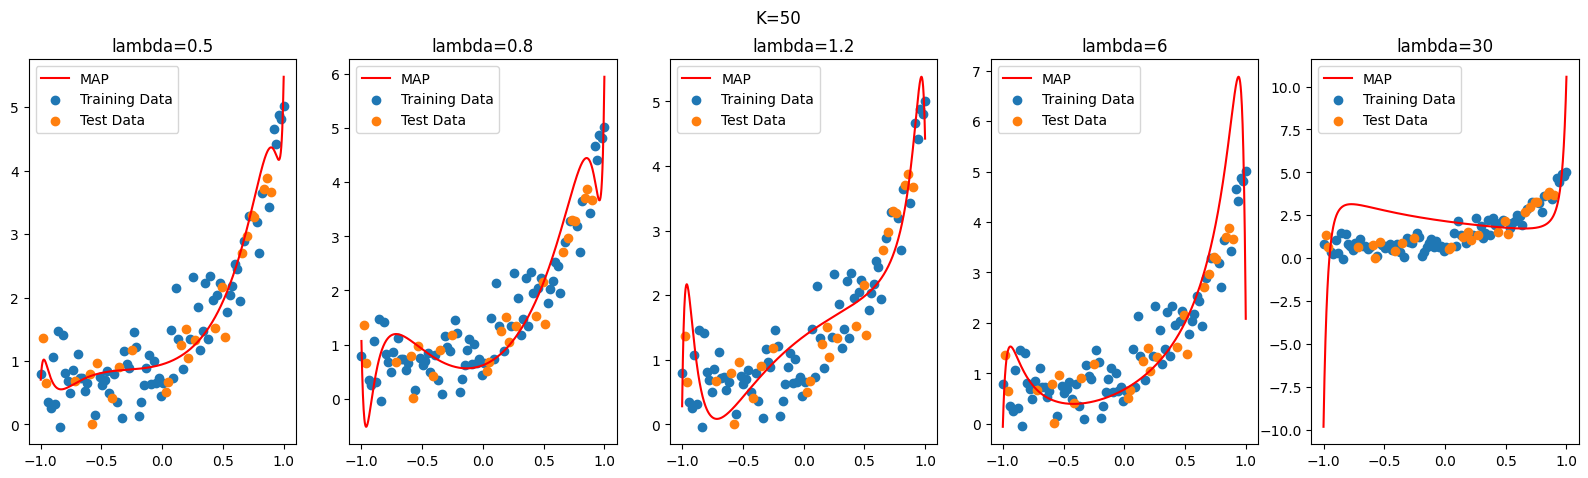

In [25]:
for i in range(len(K_values)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K={K_values[i]}")

    for j in range(len(lambdas)):
        current_theta = theta_map[i][j]

        X_plot = np.linspace(a, b, 1000)
        Y_plot = compute_f_theta(X=X_plot, K=K_values[i], theta=current_theta)
        
        plt.subplot(1, 5, j+1)
        plt.plot(X_plot, Y_plot, label=f"MAP", color="red")
        plt.scatter(Xtrain, Ytrain, label= "Training Data")
        plt.scatter(Xtest, Ytest, label="Test Data")
        plt.title(f"lambda={lambdas[j]}")
        plt.legend() 
plt.show()

We can see that the overfitting is limited increasing the lambda

The worst case is lambda = 0.5 with K = 15

### Relative Error

In [26]:
# compute the relative error for bigger values of K
thetas_error_mle = []
for k in K_values: 
    vander = get_vandermonde(k, Xtrain)
    theta = mle_ne(vander, Ytrain)
    theta_error = err_theta_true(theta, theta_true)
    thetas_error_mle.append(theta_error)

thetas_error_map = []
for lam in lambdas:
    thetas_error_map_lambda = []
    for k in K_values:
        vander = get_vandermonde(k, Xtrain)
        theta = map_ne(vander, Ytrain, lam, k)
        theta_error = err_theta_true(theta, theta_true)
        thetas_error_map_lambda.append(theta_error)   
    thetas_error_map.append(thetas_error_map_lambda)

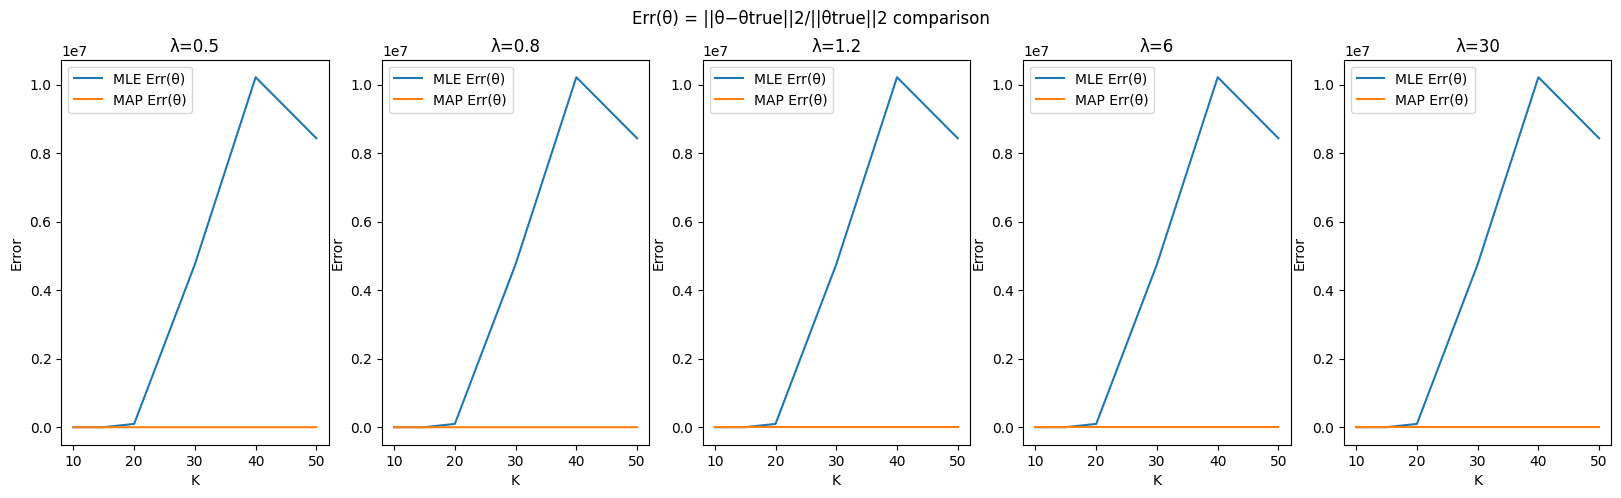

In [27]:
plt.figure(figsize = (20, 5))
plt.suptitle("Err(θ) = ||θ−θtrue||2/||θtrue||2 comparison")
for i in range(len(lambdas)):
    plt.subplot(1, 5, i+1)
    plt.plot(K_values, thetas_error_mle, label = "MLE Err(θ)")
    plt.plot(K_values, thetas_error_map[i], label = "MAP Err(θ)")
    plt.legend()
    plt.title(f"λ={lambdas[i]}")
    plt.xlabel("K")
    plt.ylabel("Error")
plt.show()

The relative error is penalized in the MLE aumenting K

On the other hand the relative error is not so big in MAP thanks to lambda

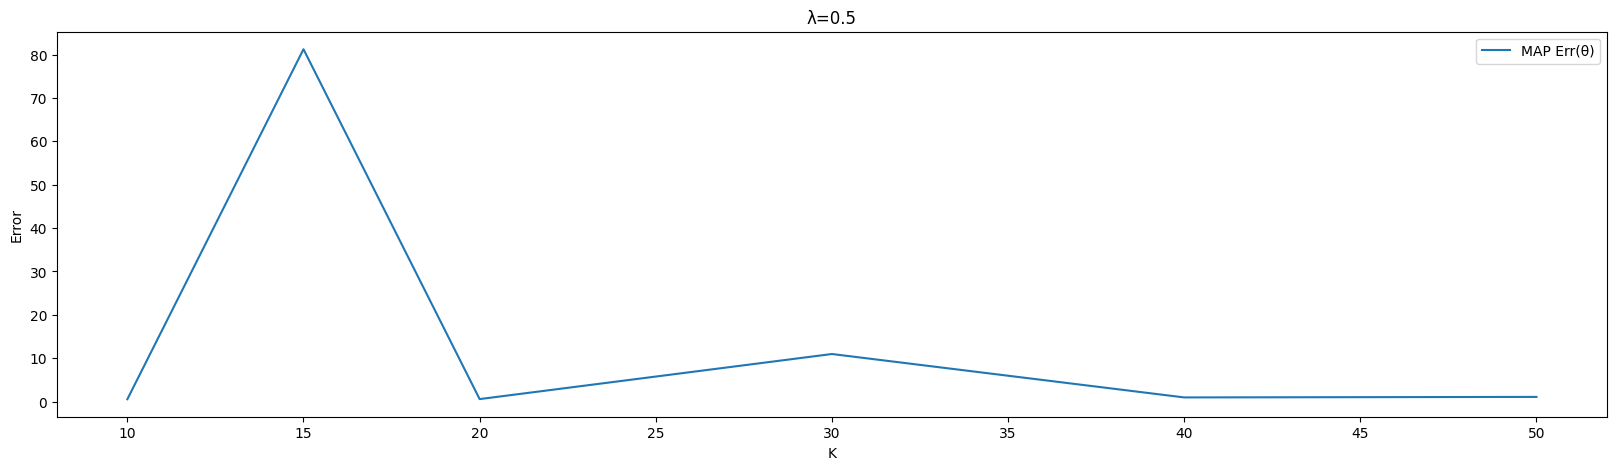

In [28]:
# Zoom-in
plt.figure(figsize = (20, 5))
plt.plot(K_values, thetas_error_map[0], label = "MAP Err(θ)")
plt.legend()
plt.title(f"λ={lambdas[0]}")
plt.xlabel("K")
plt.ylabel("Error")
plt.show()

Just a Zoom in the worst case for MAP. As we can see there is the peak in K = 15

## SGD & GD

In [70]:
K_values = [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]

In [71]:
# MLE SGD
w = []
for k in K_values:
    wk, _, _, _ = SGD(k, loss, grad_loss, np.zeros((k)), (Xtrain, Ytrain))
    w.append(wk)

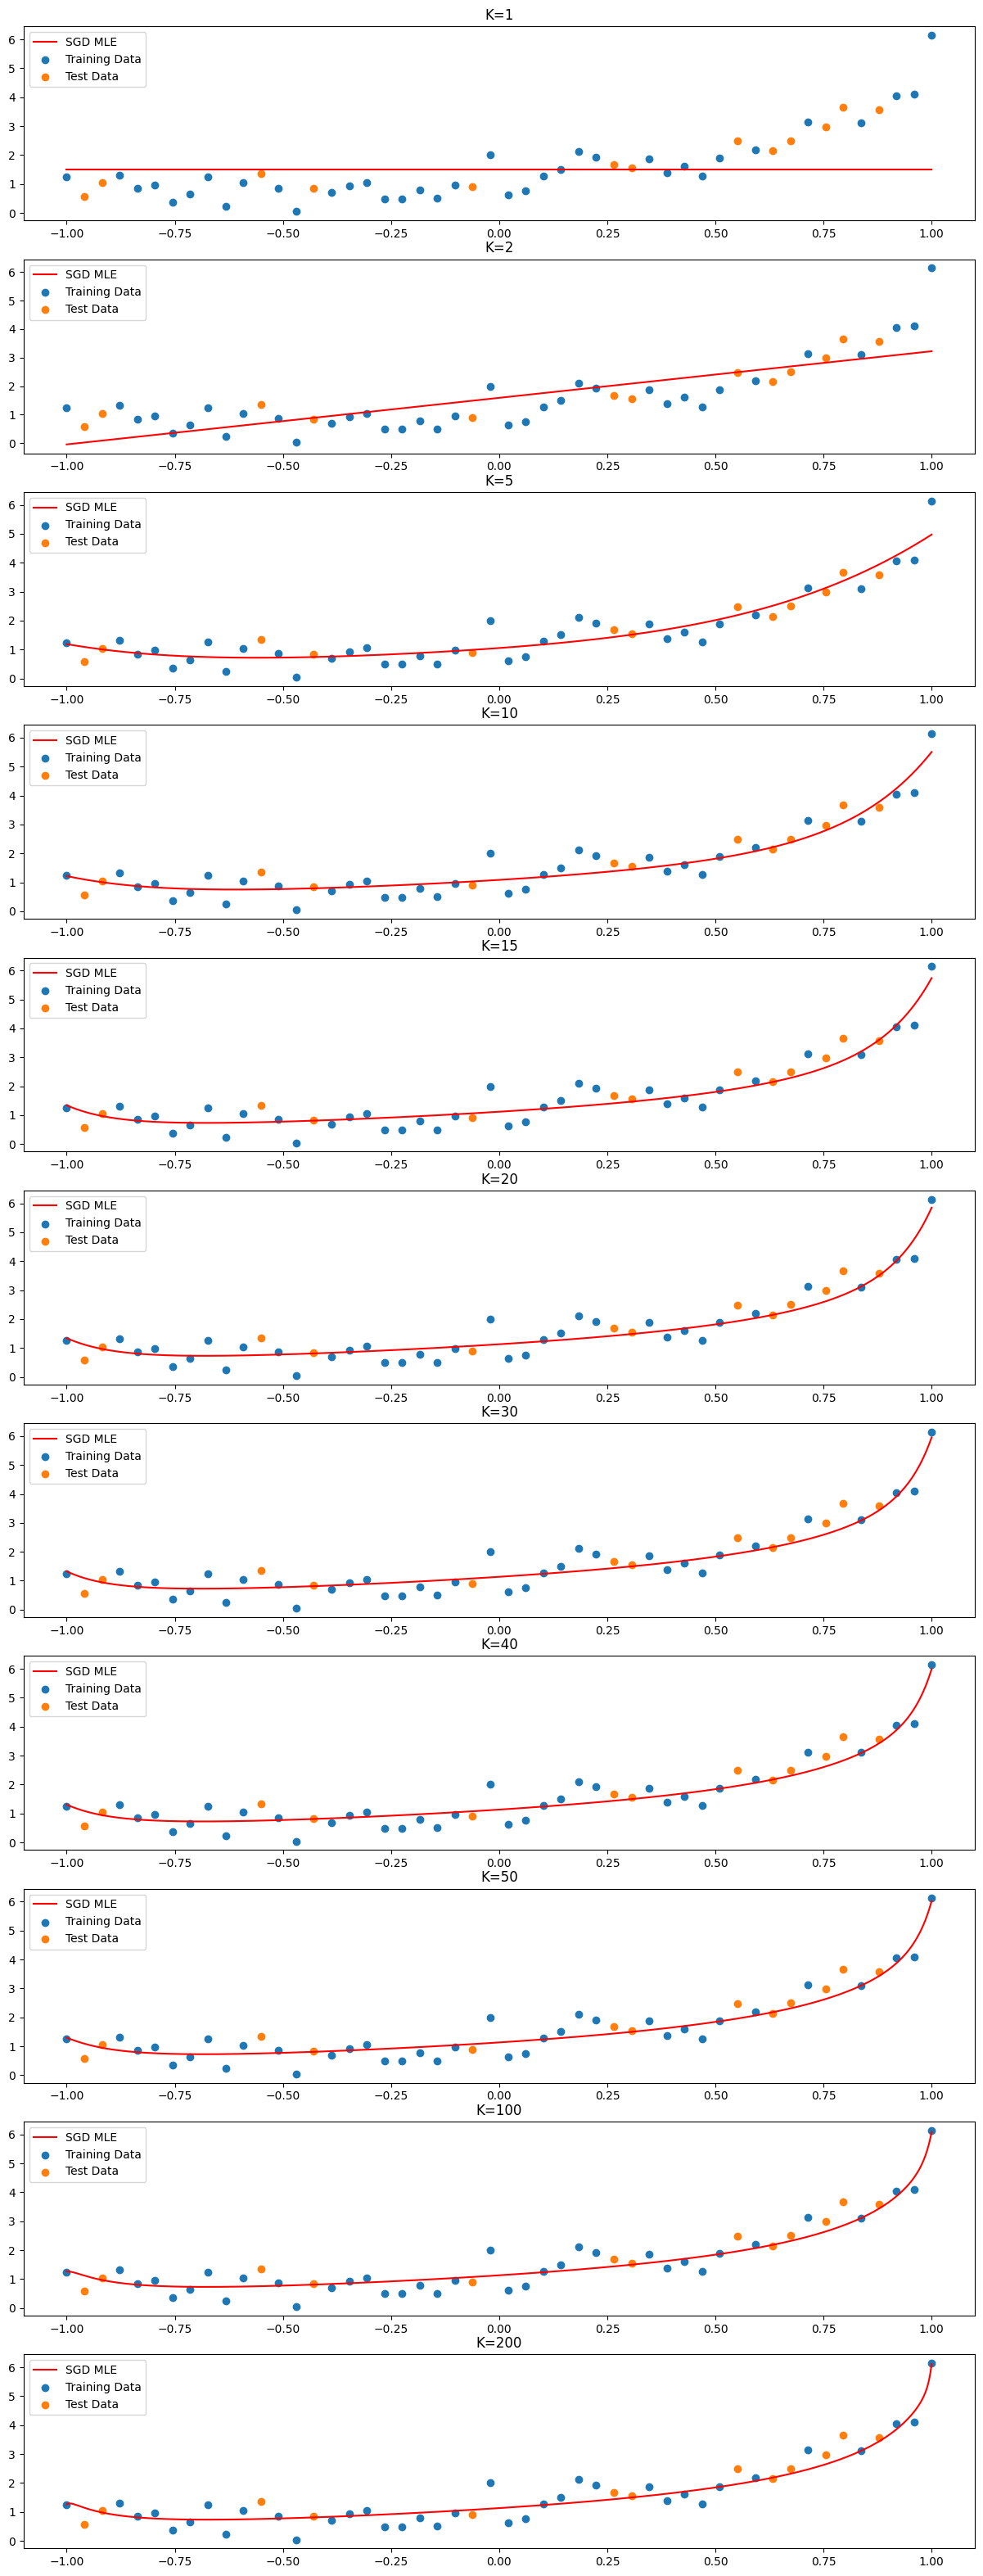

In [73]:
fig, axes = plt.subplots(nrows=len(K_values), figsize = (15, 40))

for i, ax in enumerate(axes):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = compute_f_theta(K=K_values[i], X=X_plot, theta=w[i][-1]) 
    ax.plot(X_plot, Y_plot, label = f"SGD MLE", color="red")
    ax.scatter(Xtrain, Ytrain, label="Training Data")
    ax.scatter(Xtest, Ytest, label = "Test Data")
    ax.set_title("K=" + str(K_values[i]))
    ax.legend()
plt.show()

Plotting the model, it can be observed that optimizing the parameters of the Maximum Likelihood Estimation (MLE) using stochastic gradient descent is beneficial as the model performs better with the increase of K, reaching up to 200 in the example. The method of normal equations already exhibited a significant error even at K = 30.

In [76]:
# MLE GD
w = []
for k in K_values:
    wk, _, _, _, _ = GD_back(k, grad_loss, np.zeros((k)), (Xtrain, Ytrain), loss)
    w.append(wk)

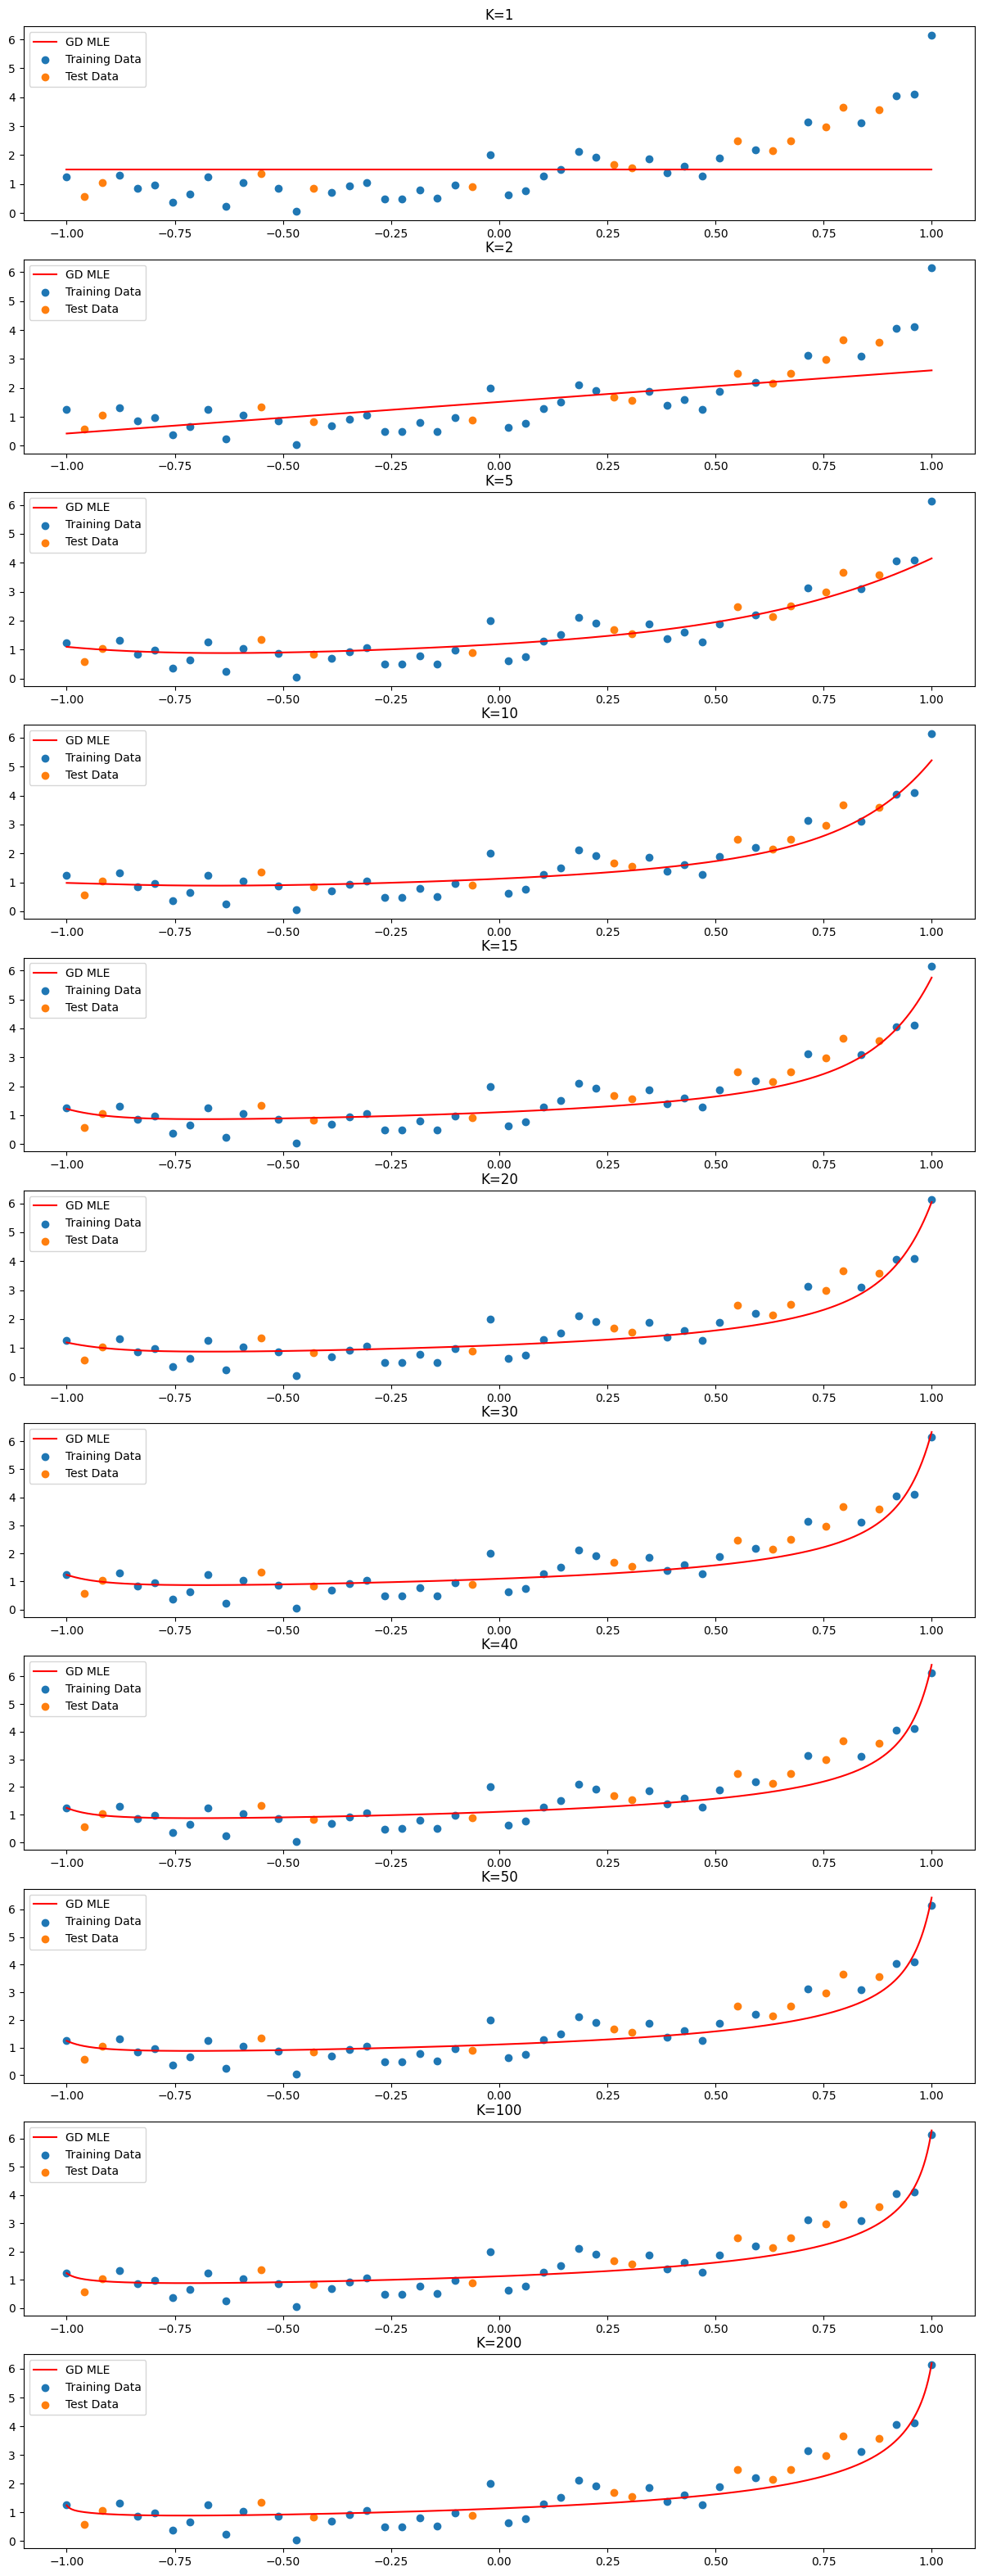

In [77]:
fig, axes = plt.subplots(nrows=len(K_values), figsize = (15, 40))

for i, ax in enumerate(axes):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = compute_f_theta(K=K_values[i], X=X_plot, theta=w[i][-1]) 
    ax.plot(X_plot, Y_plot, label = f"GD MLE", color="red")
    ax.scatter(Xtrain, Ytrain, label="Training Data")
    ax.scatter(Xtest, Ytest, label = "Test Data")
    ax.set_title("K=" + str(K_values[i]))
    ax.legend()
plt.show()

The Gradient Descent method in not affected by overfitting either

In [81]:
# MAP SGD
K_values = [1, 2, 5, 10, 15, 20, 50, 100, 200]
lambdas = [0.5, 0.8, 1.2, 6, 30]
w = []
for k in K_values:
    w_lambda = []
    for l in lambdas:
        wk, _, _, _ = SGD(k, loss, grad_loss, np.zeros((k)), (Xtrain, Ytrain), l)
        w_lambda.append(wk)
    w.append(w_lambda)

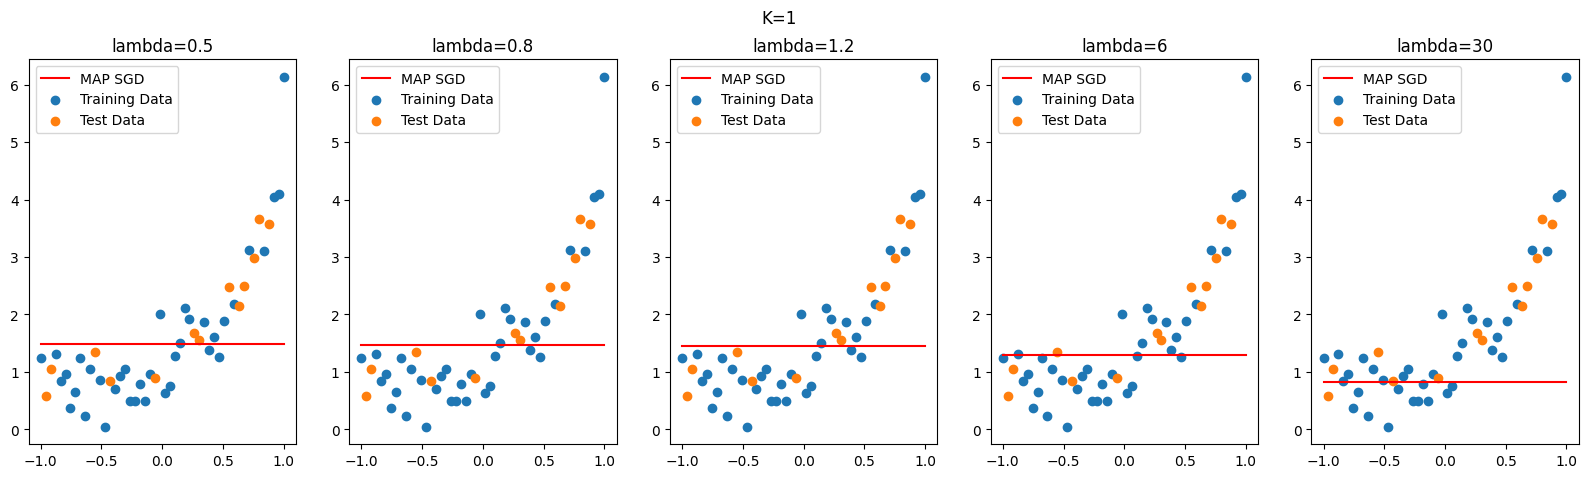

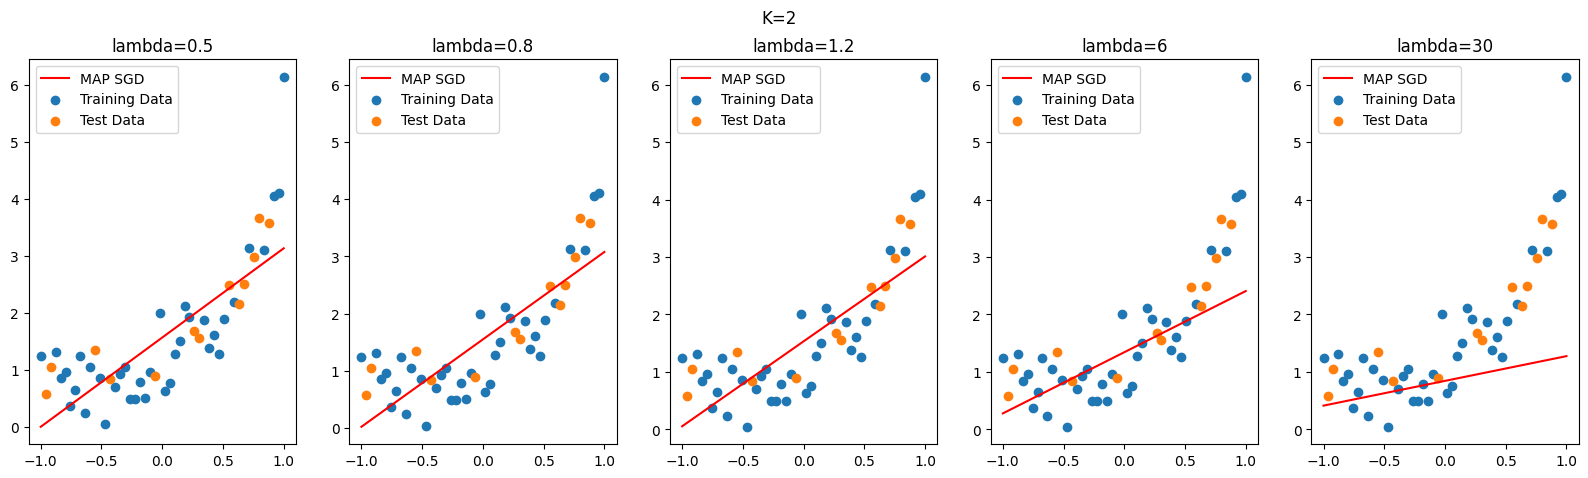

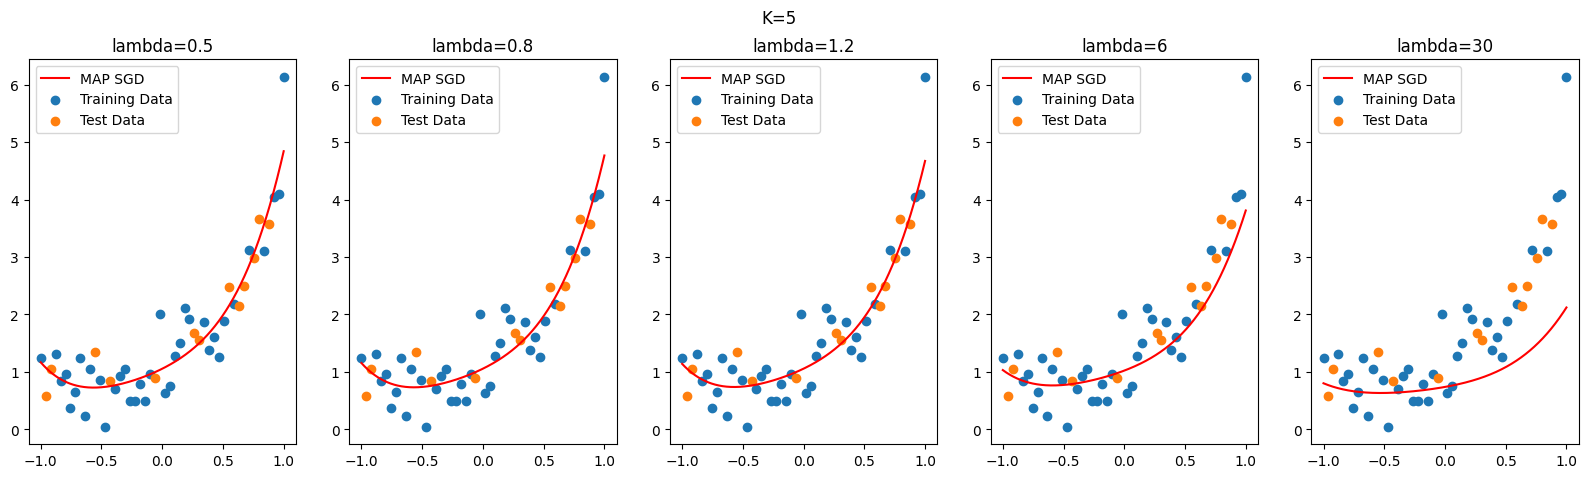

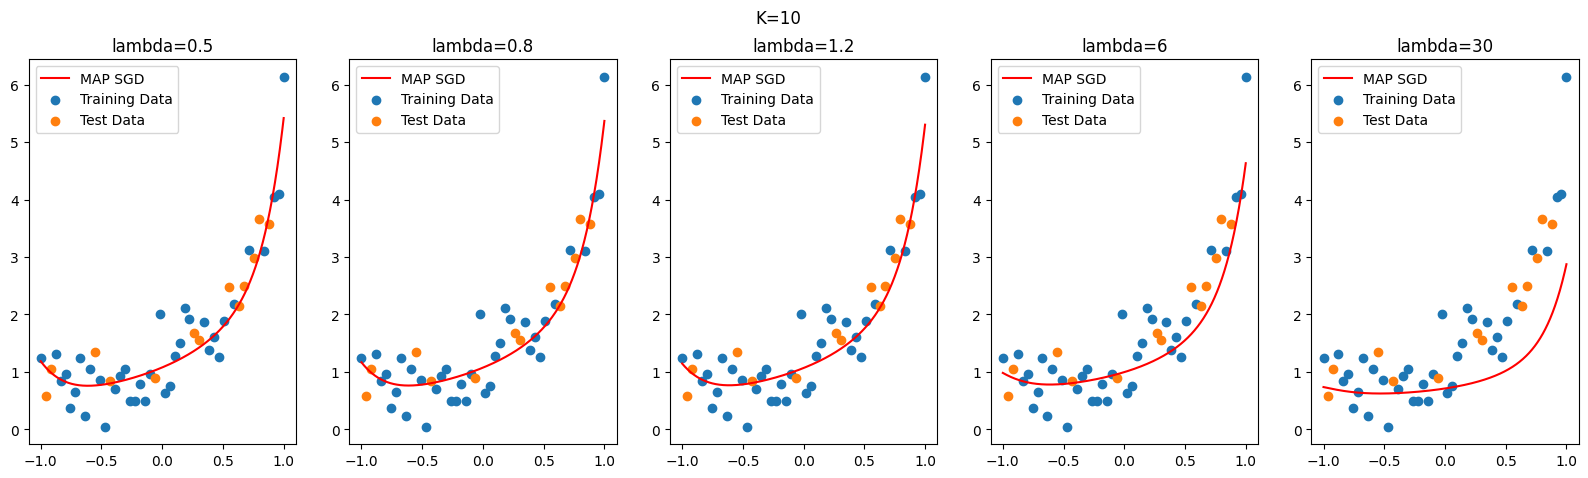

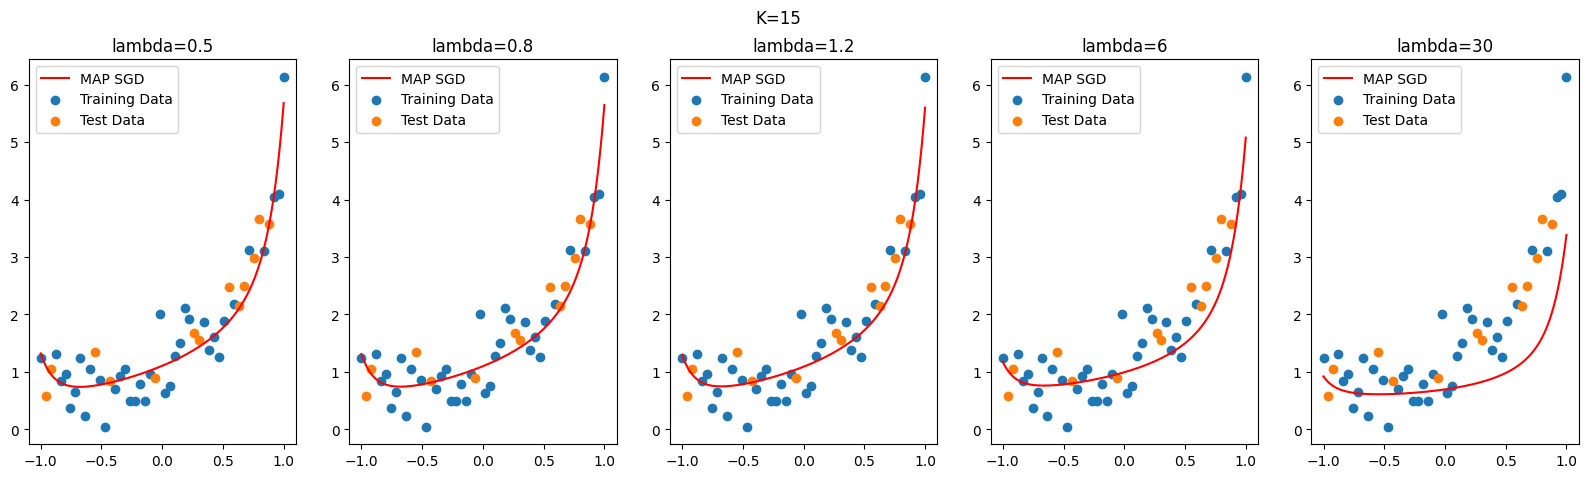

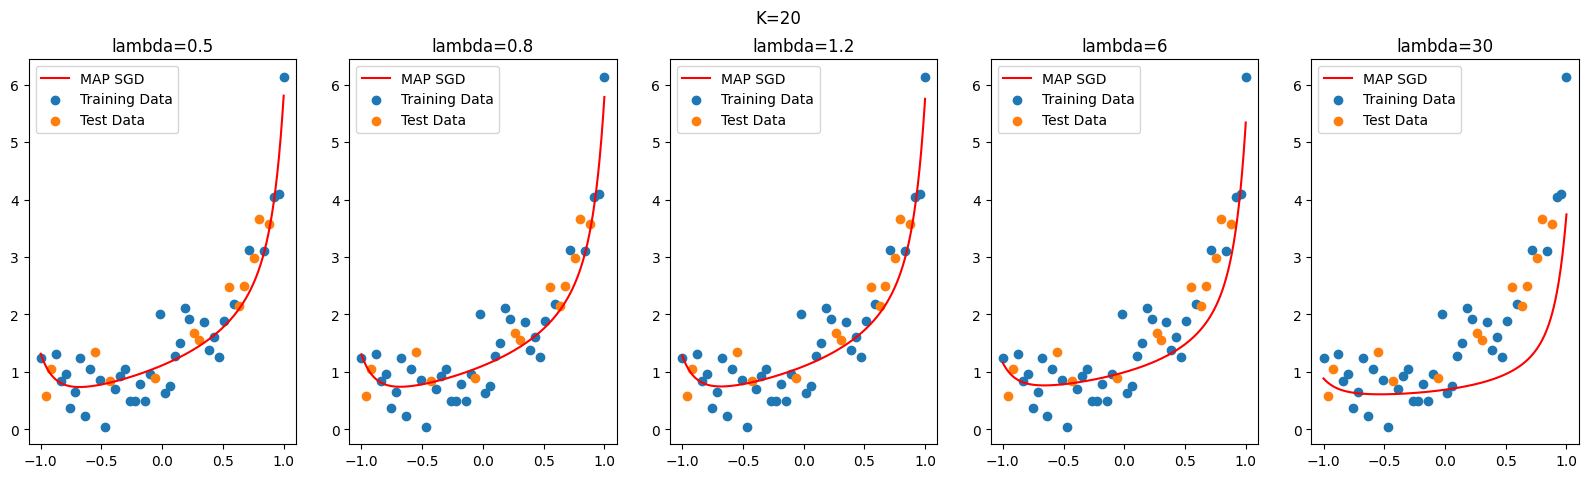

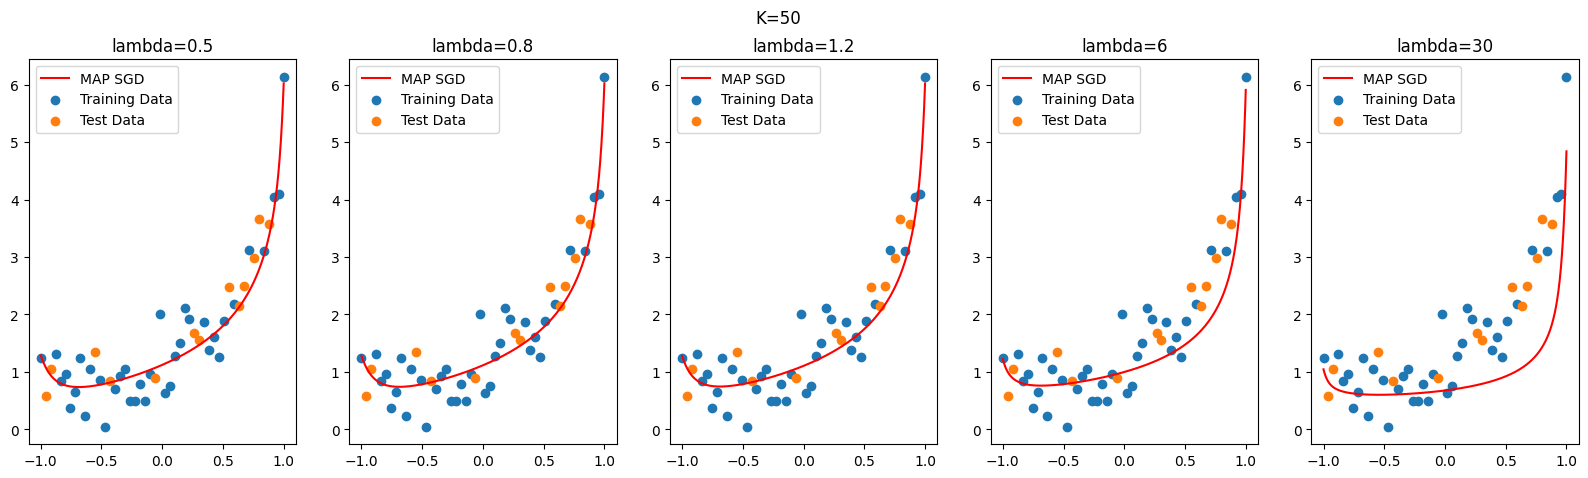

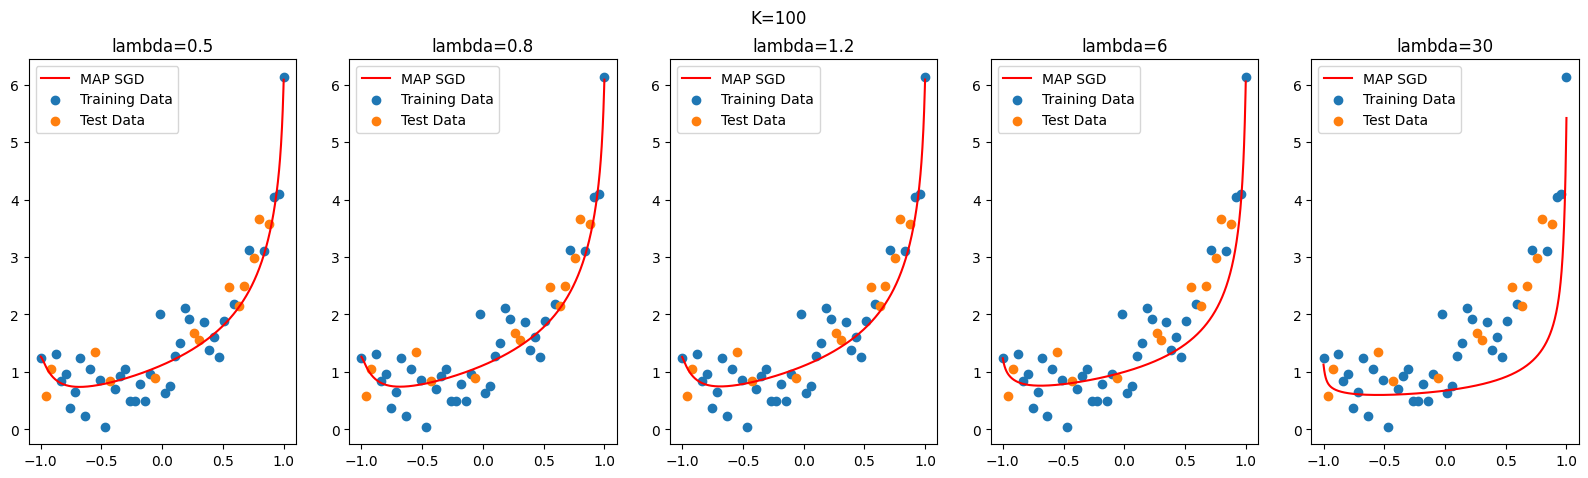

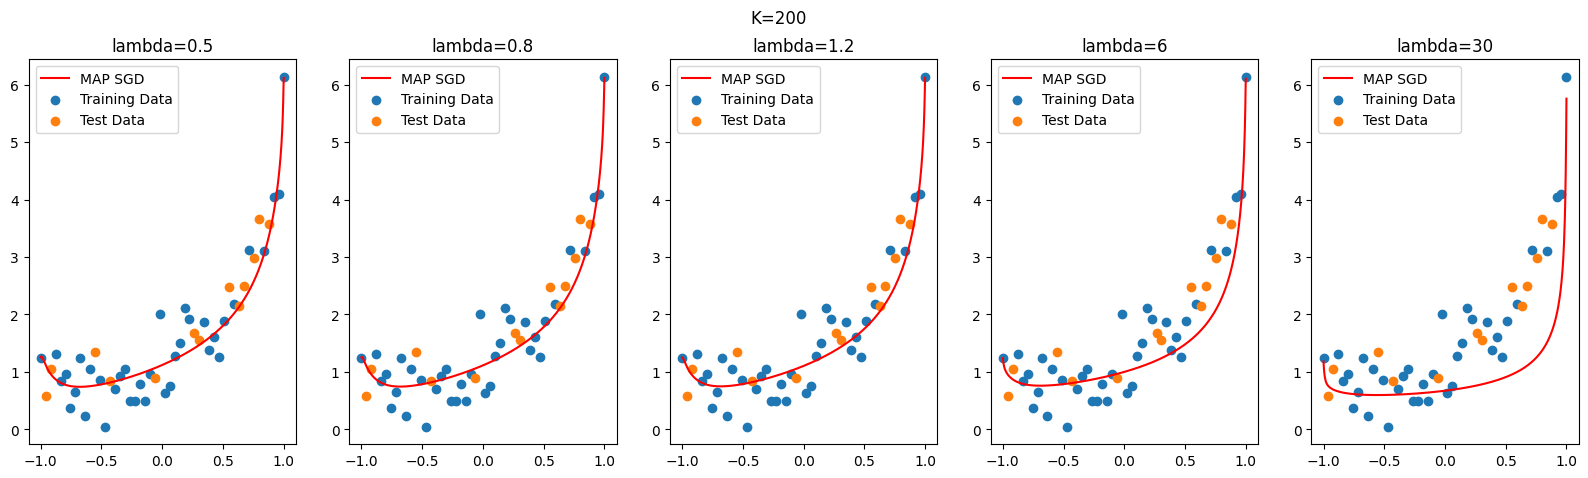

In [89]:
for i in range(len(K_values)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K={K_values[i]}")

    for j in range(len(lambdas)):
        current_w = w[i][j][-1]
        X_plot = np.linspace(a, b, 1000)
        Y_plot = compute_f_theta(X=X_plot, K=K_values[i], theta=current_w)
        
        plt.subplot(1, 5, j+1)
        plt.plot(X_plot, Y_plot, label=f"MAP SGD", color="red")
        plt.scatter(Xtrain, Ytrain, label= "Training Data")
        plt.scatter(Xtest, Ytest, label="Test Data")
        plt.title(f"lambda={lambdas[j]}")
        plt.legend() 
plt.show()

In [90]:
# MAP GD
w = []
for k in K_values:
    w_lambda = []
    for l in lambdas:
        wk, _, _, _, _ = GD_back(k, grad_loss, np.zeros((k)), (Xtrain, Ytrain), loss, l)
        w_lambda.append(wk)
    w.append(w_lambda)

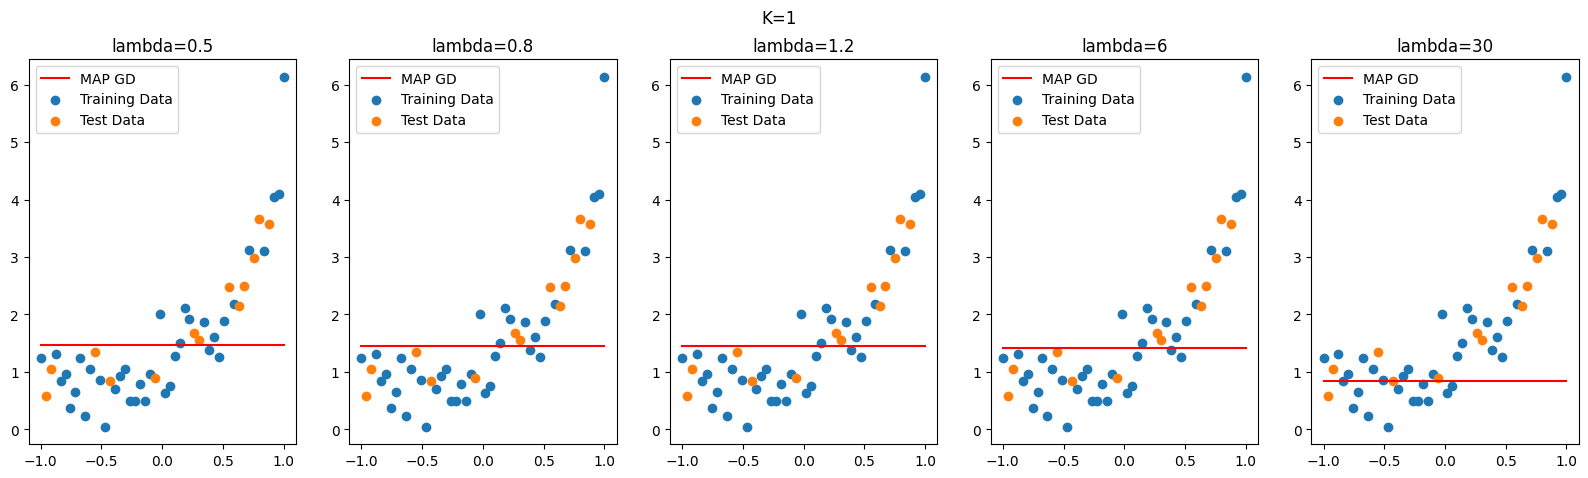

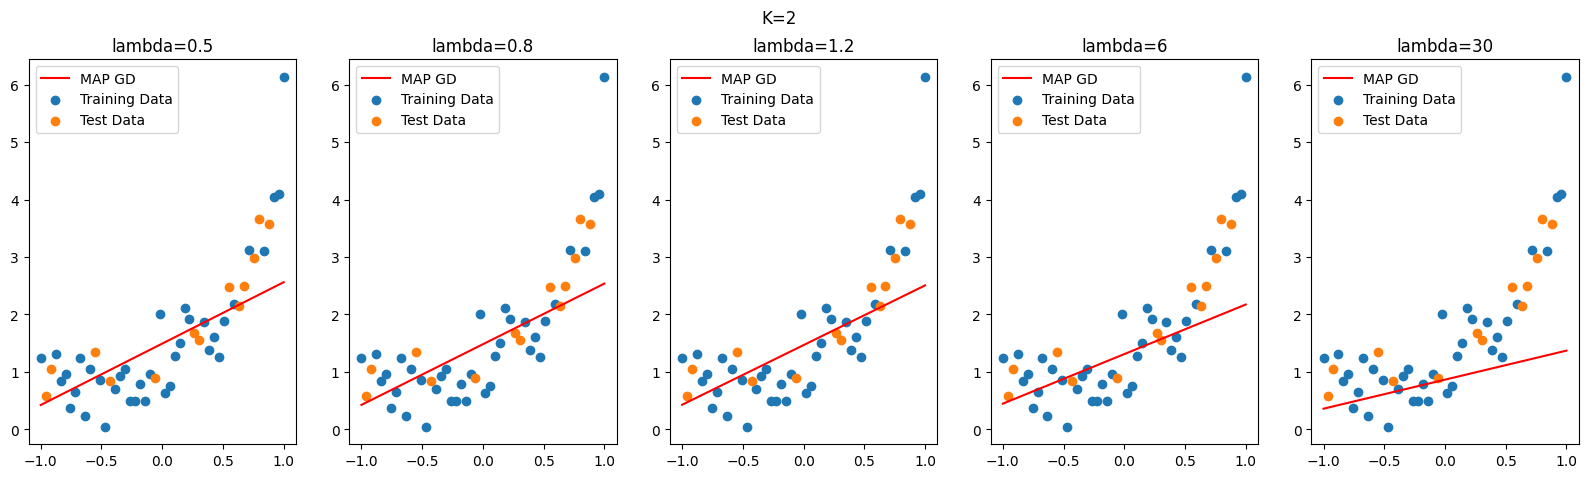

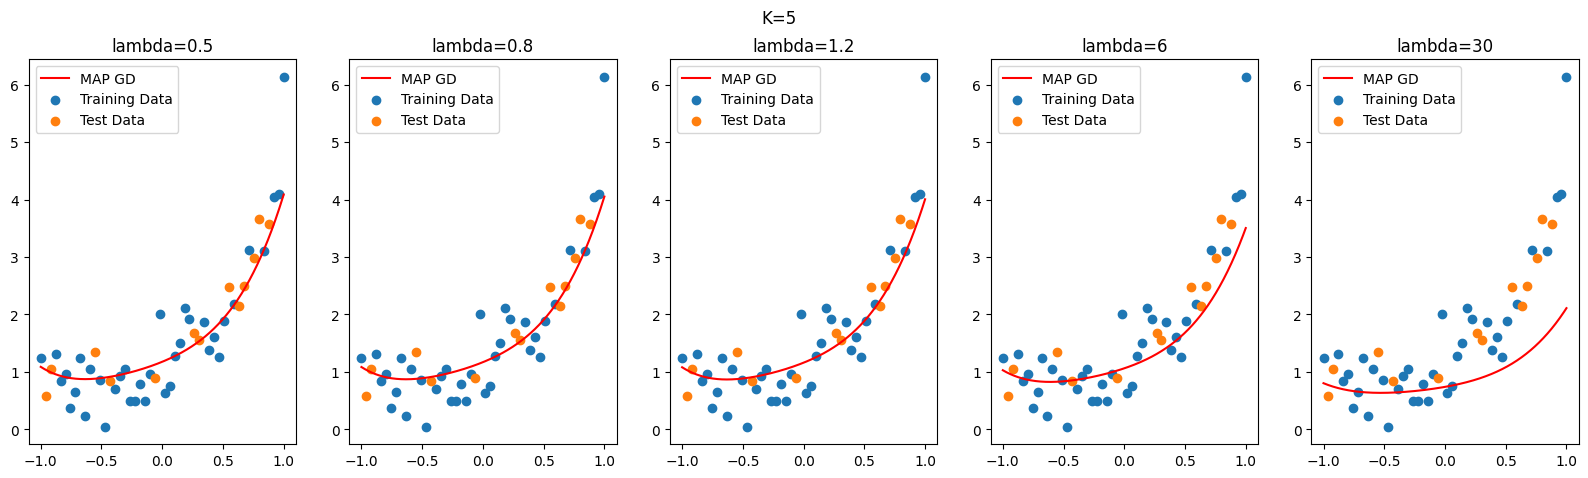

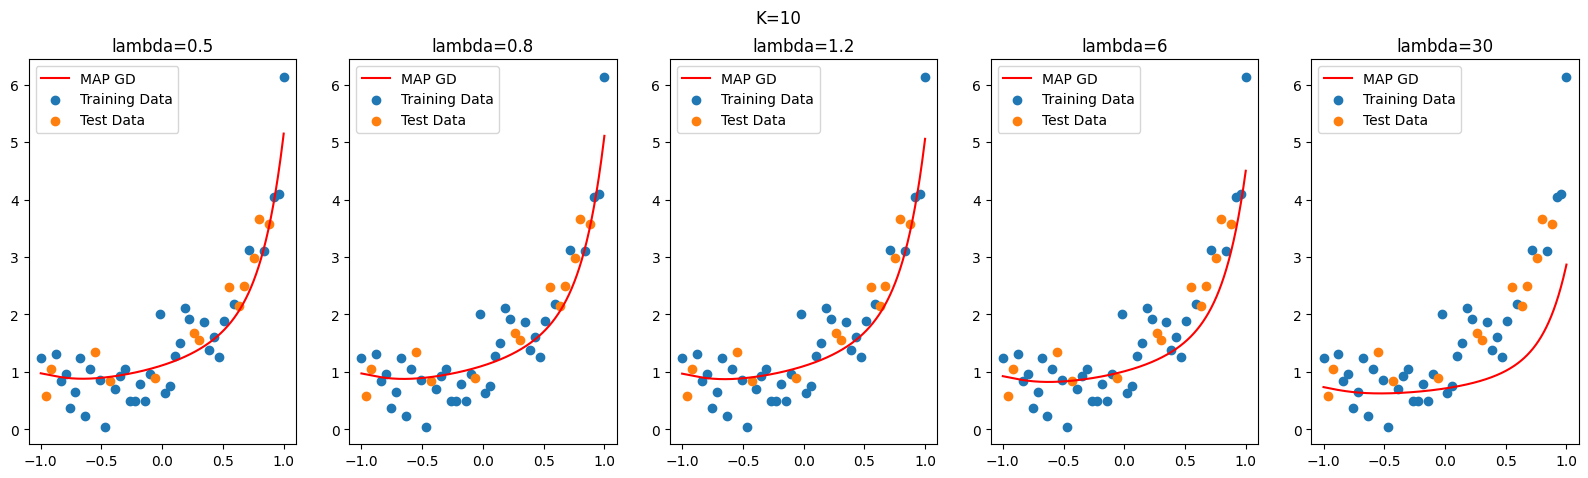

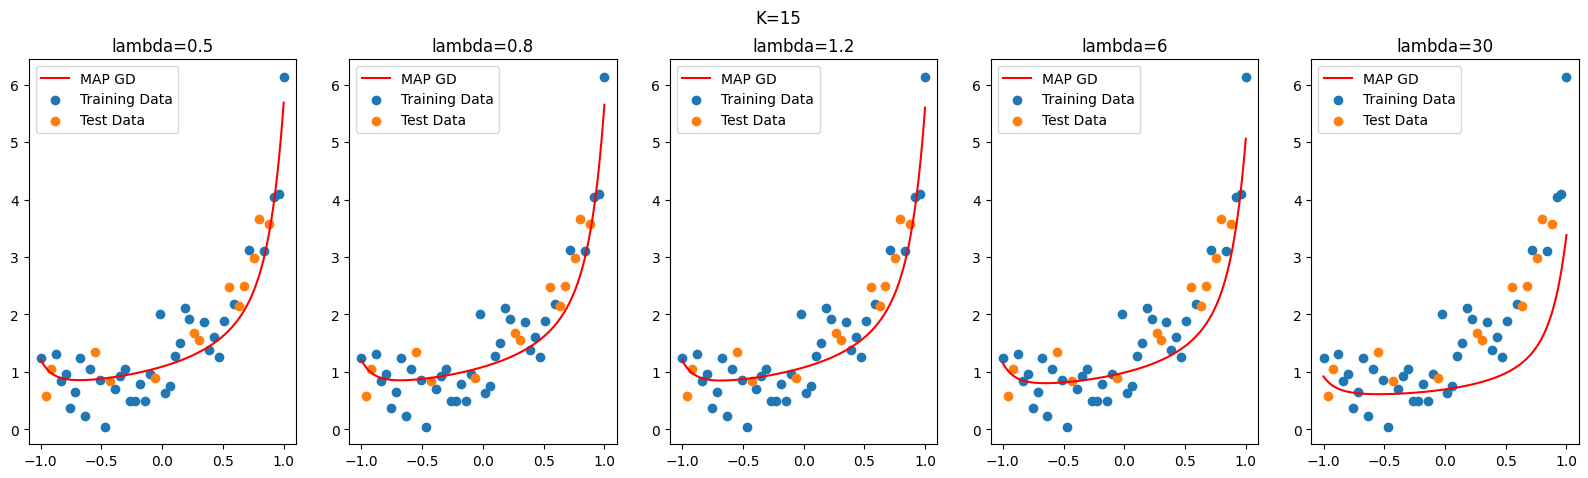

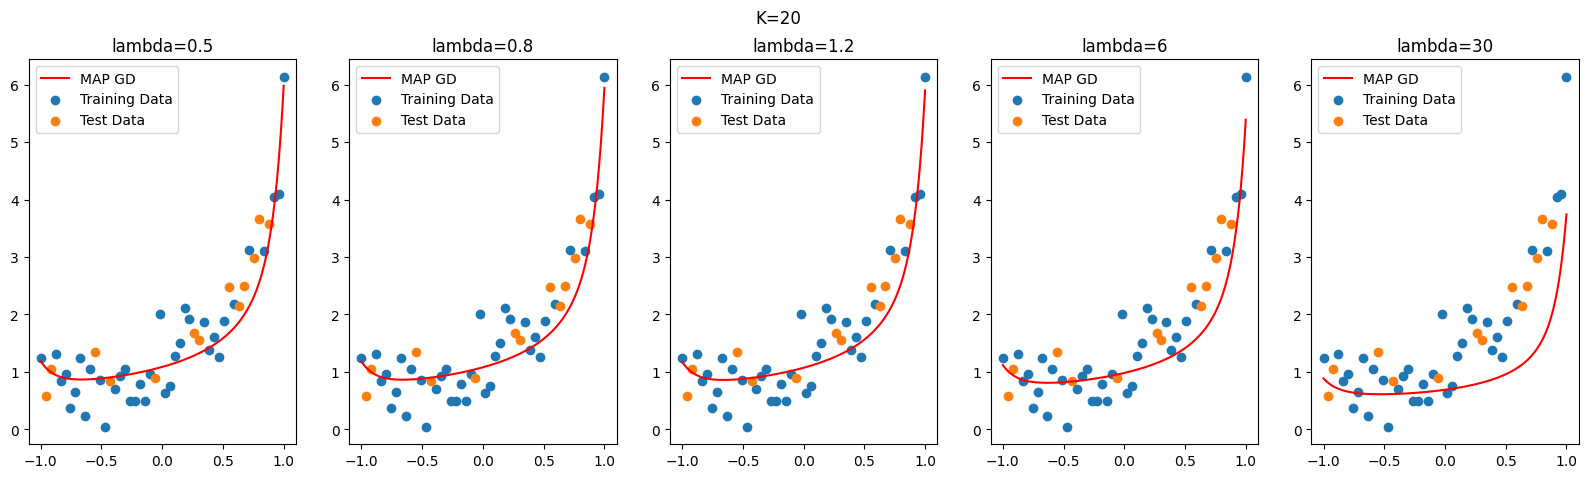

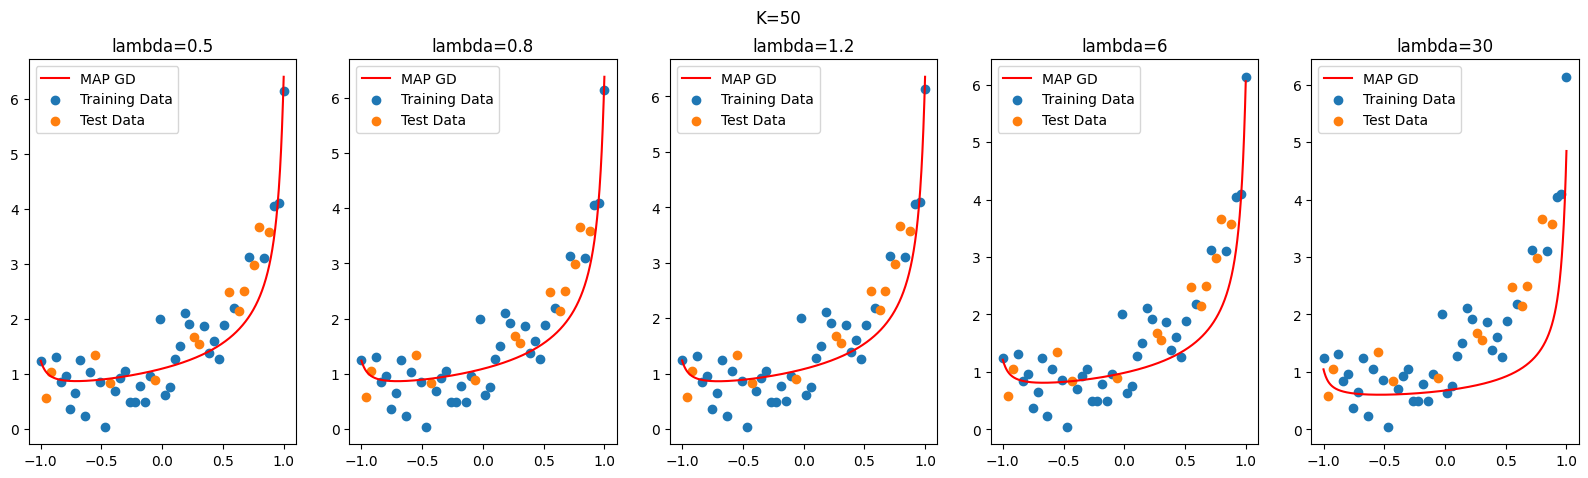

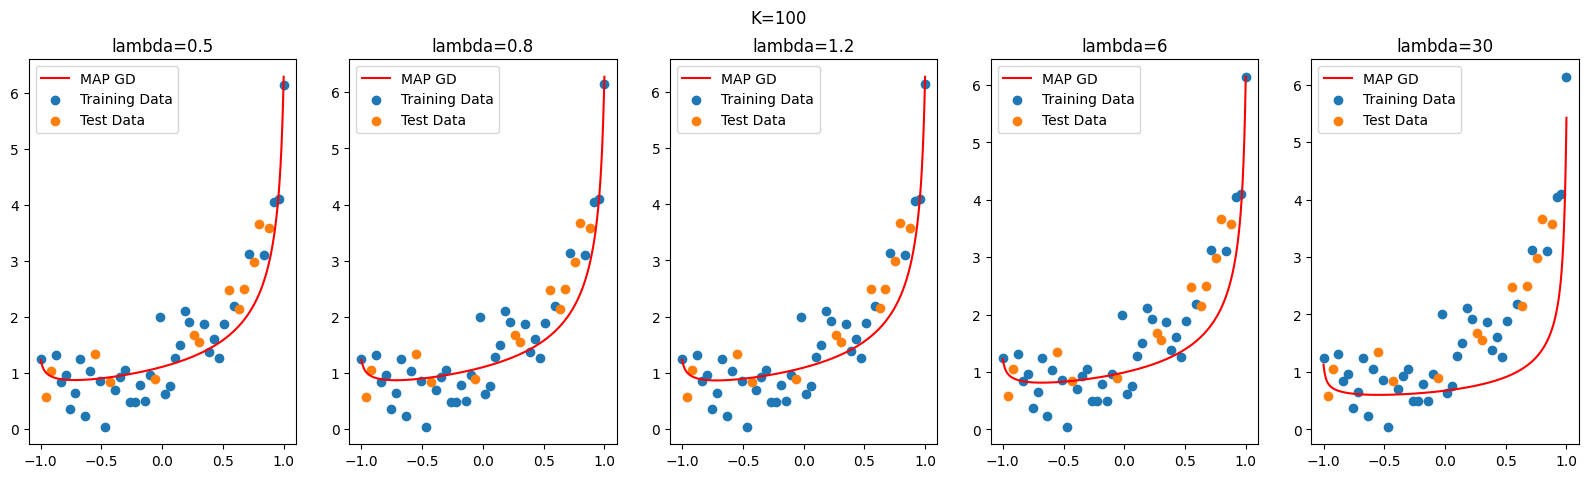

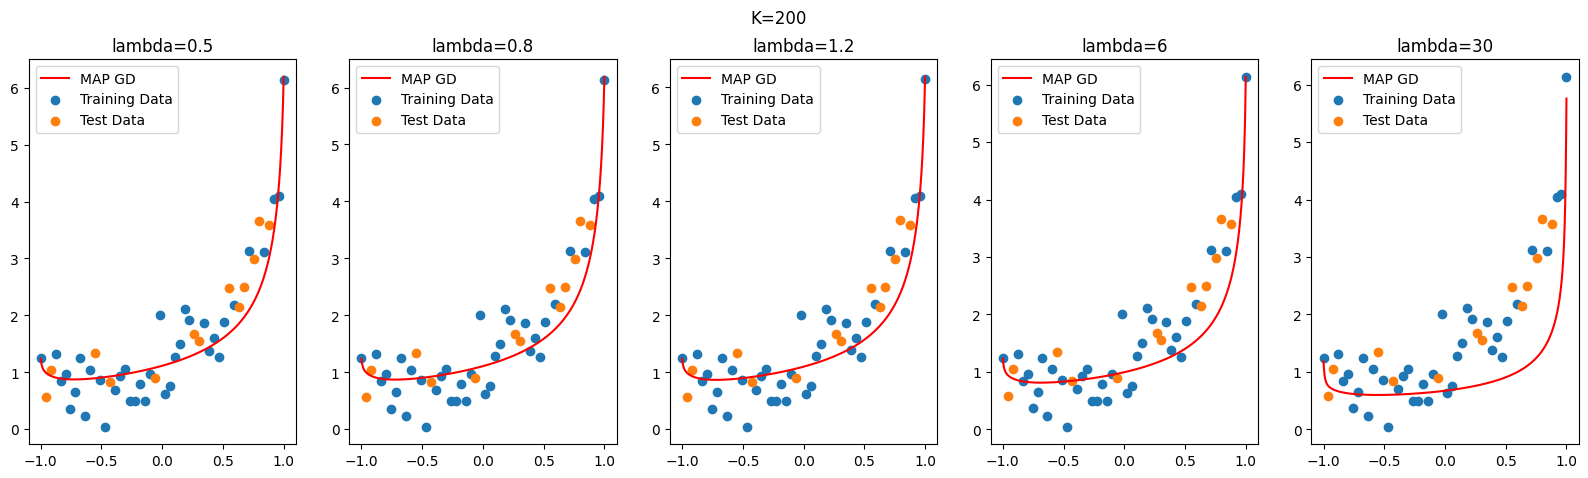

In [91]:
for i in range(len(K_values)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K={K_values[i]}")

    for j in range(len(lambdas)):
        current_w = w[i][j][-1]
        X_plot = np.linspace(a, b, 1000)
        Y_plot = compute_f_theta(X=X_plot, K=K_values[i], theta=current_w)
        
        plt.subplot(1, 5, j+1)
        plt.plot(X_plot, Y_plot, label=f"MAP GD", color="red")
        plt.scatter(Xtrain, Ytrain, label= "Training Data")
        plt.scatter(Xtest, Ytest, label="Test Data")
        plt.title(f"lambda={lambdas[j]}")
        plt.legend() 
plt.show()

## N bigger

In [111]:
# Compare the results obtained by increasing the number N of datapoints

# Relative errors and Test errors
np.random.seed(42)
N_l = [50, 100, 200, 500]
K_values = [1, 2, 5, 10, 15, 20, 50, 100, 200]

test_errors_mle_ne = []
test_errors_mle_SGD = []
test_errors_mle_GD = []

relative_mle_ne = []
relative_mle_SGD = []
relative_mle_GD = []

for i in range(len(N_l)):
    n = N_l[i]
    # Dataset preparation
    X = np.linspace(a, b, n)
    Y = compute(K, X, theta_true, v=0.15) 

    # dataset split
    idx = np.arange(n)
    np.random.shuffle(idx)
    N_train = int(n/4*3) # 75 per cent
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]
    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]
    Xtest = X[test_idx]
    Ytest = Y[test_idx]
    Dtrain = (Xtrain, Ytrain)
    Dtest = (Xtest, Ytest)

    test_errors_mle_ne_k = []
    test_errors_mle_SGD_k = []
    test_errors_mle_GD_k = []
    relative_mle_ne_k = []
    relative_mle_SGD_k = []
    relative_mle_GD_k = []
    
    for k in K_values: 
        vander = get_vandermonde(k, Xtrain)
        theta_ne = mle_ne(vander, Ytrain)
        theta_SGD, _, _, _ = SGD(k, loss, grad_loss, np.zeros((k)), (Xtrain, Ytrain))
        theta_GD, _, _, _, _ = GD_back(k, grad_loss, np.zeros((k)), (Xtrain, Ytrain), loss)
        test_errors_mle_ne_k.append(avg_error(D=Dtest, theta=theta_ne))
        test_errors_mle_SGD_k.append(avg_error(D=Dtest, theta=theta_SGD[-1]))
        test_errors_mle_GD_k.append(avg_error(D=Dtest, theta=theta_GD[-1]))
        if k > K:
            relative_mle_ne_k.append(err_theta_true(theta_ne, theta_true))
            relative_mle_SGD_k.append(err_theta_true(theta_SGD[-1], theta_true))
            relative_mle_GD_k.append(err_theta_true(theta_GD[-1], theta_true))

    test_errors_mle_ne.append(test_errors_mle_ne_k)
    test_errors_mle_SGD.append(test_errors_mle_SGD_k)
    test_errors_mle_GD.append(test_errors_mle_GD_k)

    relative_mle_ne.append(relative_mle_ne_k)
    relative_mle_SGD.append(relative_mle_SGD_k)
    relative_mle_GD.append(relative_mle_GD_k)


In [112]:
np.random.seed(42)
lambdas = [0.5, 0.8, 1.2, 6, 30]

test_errors_map_ne = []
test_errors_map_SGD = []
test_errors_map_GD = []

relative_map_ne = []
relative_map_SGD = []
relative_map_GD = []

for i in range(len(N_l)):
    n = N_l[i]
    X = np.linspace(a, b, n)
    Y = compute(K, X, theta_true, v=0.15) 

    # dataset split
    idx = np.arange(n)
    np.random.shuffle(idx)
    N_train = int(n/4*3) # 75 per cent
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]
    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]
    Xtest = X[test_idx]
    Ytest = Y[test_idx]
    Dtrain = (Xtrain, Ytrain)
    Dtest = (Xtest, Ytest)

    test_errors_map_ne_l = []
    test_errors_map_SGD_l = []
    test_errors_map_GD_l = []
    relative_map_ne_l = []
    relative_map_SGD_l = []
    relative_map_GD_l = []

    for lam in lambdas:
        test_errors_map_ne_k = []
        test_errors_map_SGD_k = []
        test_errors_map_GD_k = []
        relative_map_ne_k = []
        relative_map_SGD_k = []
        relative_map_GD_k = []
        for k in K_values:
            vander = get_vandermonde(k, Xtrain)
            theta_ne = map_ne(vander, Ytrain, lam, k)
            theta_SGD, _, _, _ = SGD(k, loss, grad_loss, np.zeros((k)), (Xtrain, Ytrain), l)
            theta_GD, _, _, _, _ = GD_back(k, grad_loss, np.zeros((k)), (Xtrain, Ytrain), loss, l)
            test_errors_map_ne_k.append(avg_error(D=Dtest, theta=theta_ne))
            test_errors_map_SGD_k.append(avg_error(D=Dtest, theta=theta_SGD[-1]))
            test_errors_map_GD_k.append(avg_error(D=Dtest, theta=theta_GD[-1]))
            if k > K:
                relative_map_ne_k.append(err_theta_true(theta_ne, theta_true))
                relative_map_SGD_k.append(err_theta_true(theta_SGD[-1], theta_true))
                relative_map_GD_k.append(err_theta_true(theta_GD[-1], theta_true)) 
        test_errors_map_ne_l.append(test_errors_map_ne_k)
        test_errors_map_SGD_l.append(test_errors_map_SGD_k)
        test_errors_map_GD_l.append(test_errors_map_GD_k)
        relative_map_ne_l.append(relative_map_ne_k)
        relative_map_SGD_l.append(relative_map_SGD_k)
        relative_map_GD_l.append(relative_map_GD_k)
    test_errors_map_ne.append(test_errors_map_ne_l)
    test_errors_map_SGD.append(test_errors_map_SGD_l)
    test_errors_map_GD.append(test_errors_map_GD_l)
    relative_map_ne.append(relative_map_ne_l)
    relative_map_SGD.append(relative_map_SGD_l)
    relative_map_GD.append(relative_map_GD_l)        

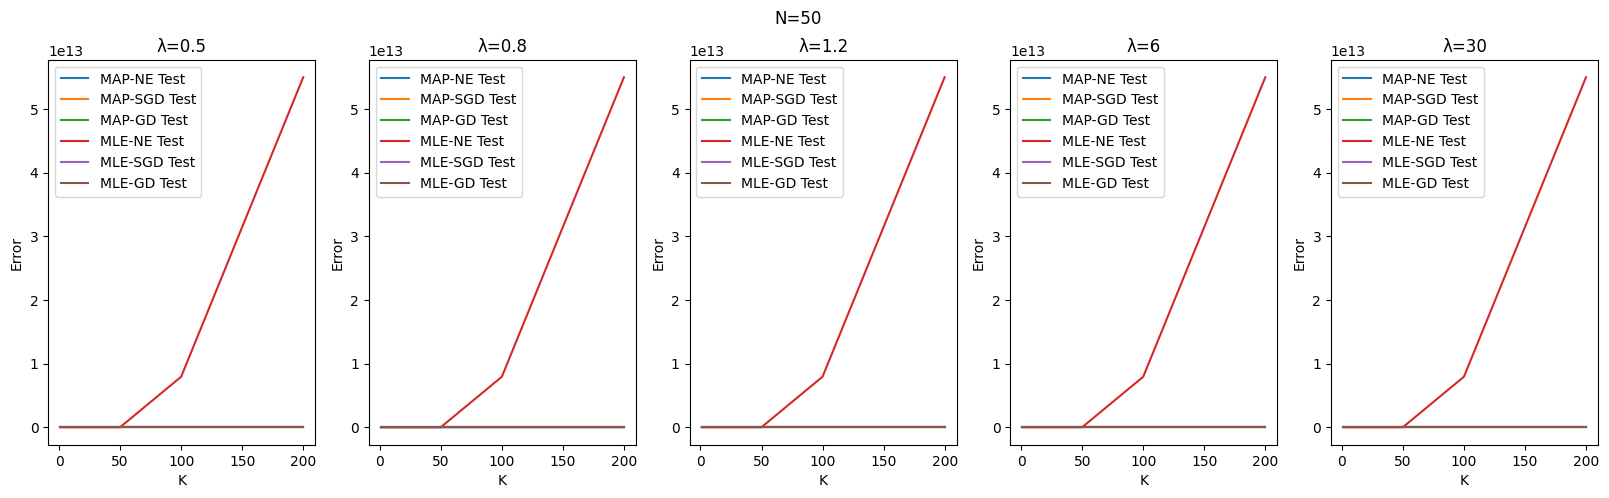

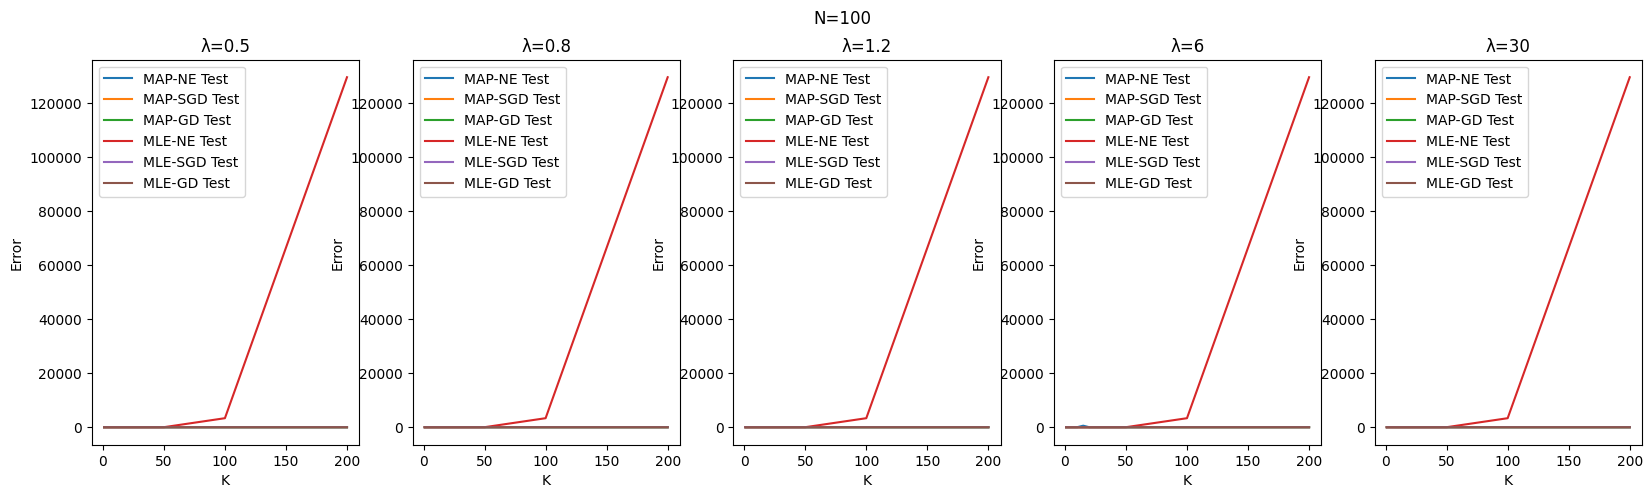

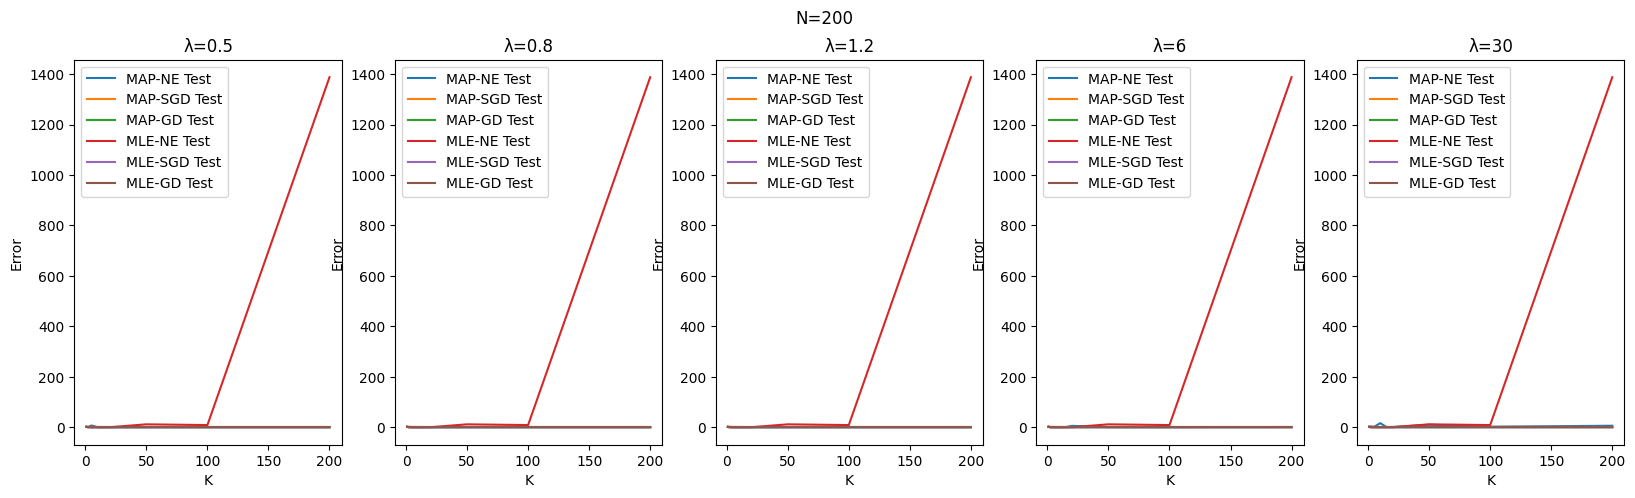

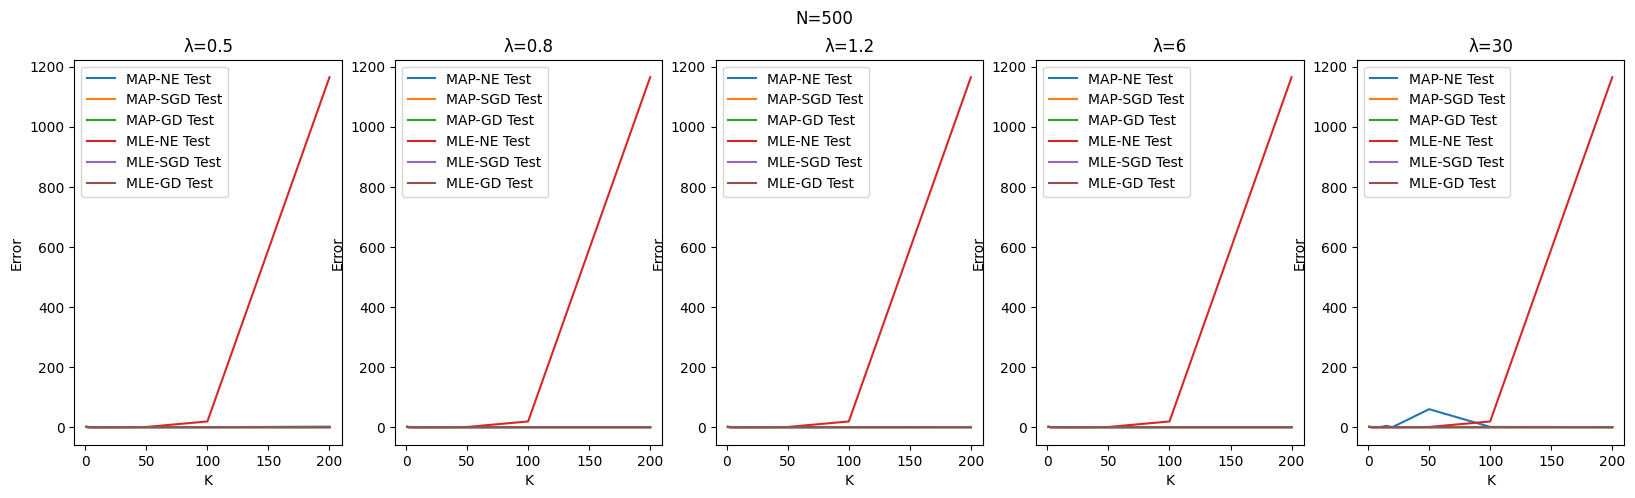

In [122]:
# Plot Test error
for i in range(len(N_l)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"N={N_l[i]}")
    for j in range(len(lambdas)):
        plt.subplot(1, 5, j+1)
        plt.plot(K_values, test_errors_map_ne[i][j], label = "MAP-NE Test")
        plt.plot(K_values, test_errors_map_SGD[i][j], label = "MAP-SGD Test")
        plt.plot(K_values, test_errors_map_GD[i][j], label = "MAP-GD Test")
        plt.plot(K_values, test_errors_mle_ne[i], label = "MLE-NE Test")
        plt.plot(K_values, test_errors_mle_SGD[i], label = "MLE-SGD Test")
        plt.plot(K_values, test_errors_mle_GD[i], label = "MLE-GD Test")
        plt.legend()
        plt.title(f"λ={lambdas[j]}")
        plt.xlabel("K")
        plt.ylabel("Error") 
plt.show()

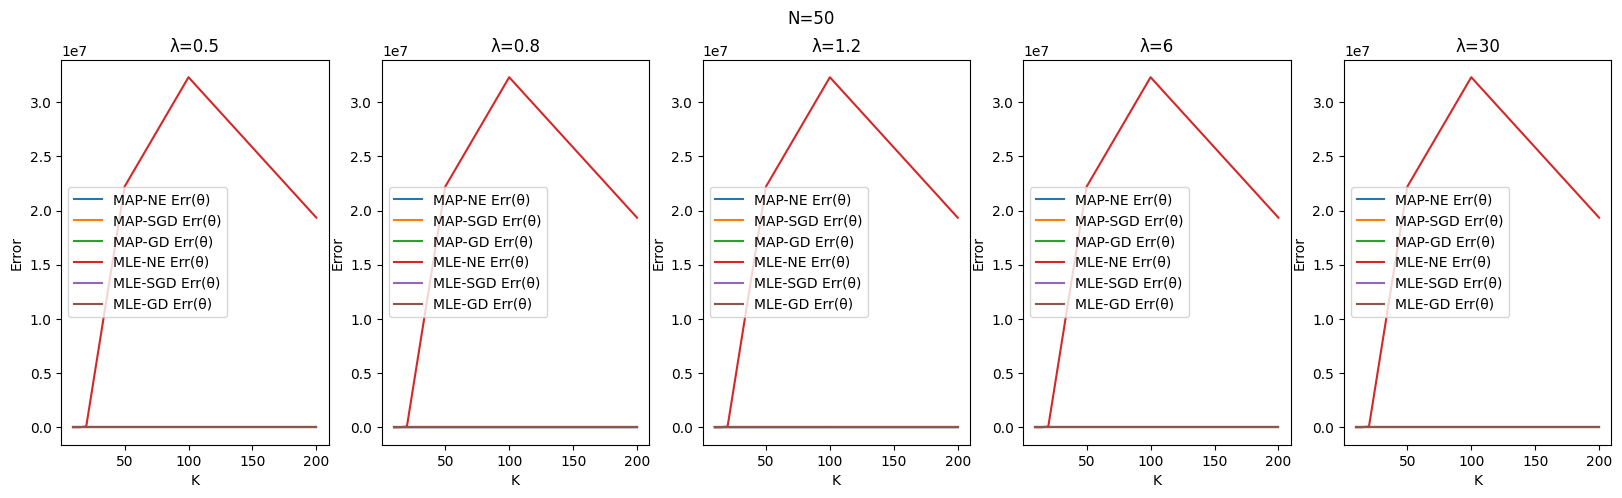

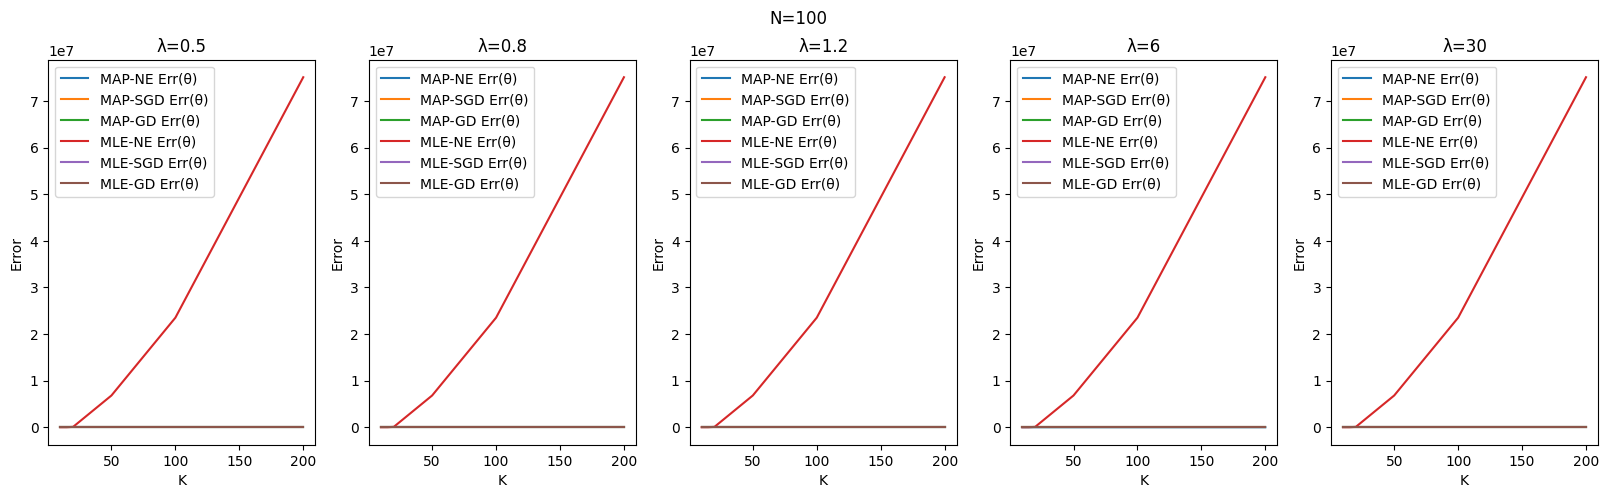

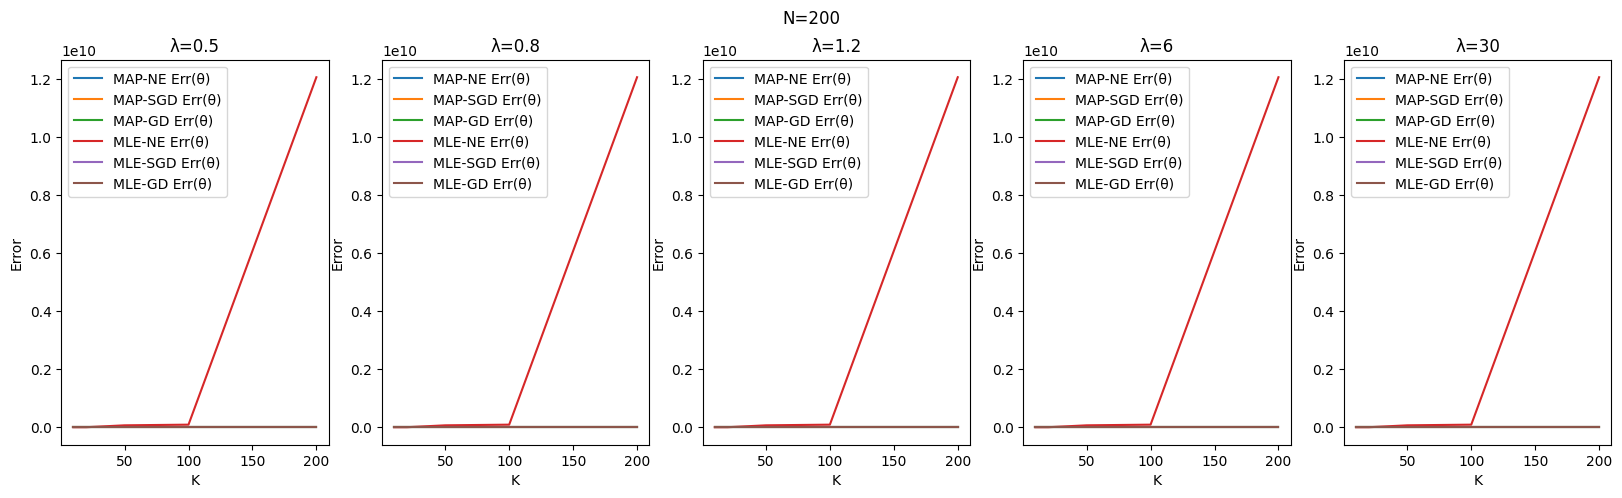

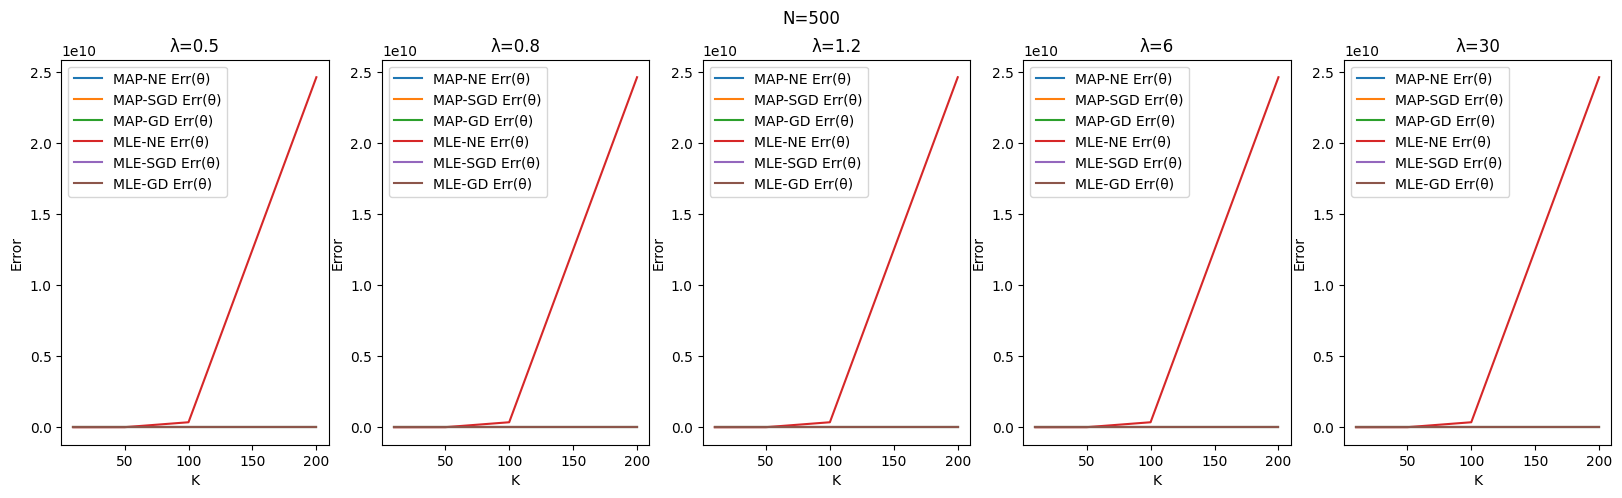

In [123]:
# Plot Relative error
K_v = [10, 15, 20, 50, 100, 200]
for i in range(len(N_l)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"N={N_l[i]}")
    for j in range(len(lambdas)):
        plt.subplot(1, 5, j+1)
        plt.plot(K_v, relative_map_ne[i][j], label = "MAP-NE Err(θ)")
        plt.plot(K_v, relative_map_SGD[i][j], label = "MAP-SGD Err(θ)")
        plt.plot(K_v, relative_map_GD[i][j], label = "MAP-GD Err(θ)")
        plt.plot(K_v, relative_mle_ne[i], label = "MLE-NE Err(θ)")
        plt.plot(K_v, relative_mle_SGD[i], label = "MLE-SGD Err(θ)")
        plt.plot(K_v, relative_mle_GD[i], label = "MLE-GD Err(θ)")
        plt.legend()
        plt.title(f"λ={lambdas[j]}")
        plt.xlabel("K")
        plt.ylabel("Error") 
plt.show()

#### MLE resolution with Normal equation shows the worst behaviour overall.

An increase of the number of Ntrain is essential for MLE with normal equation resolution if we want a good approssimation of the solution with the increase of K.